## Advanced Lane Finding
[![Udacity - Self-Driving Car NanoDegree](https://s3.amazonaws.com/udacity-sdc/github/shield-carnd.svg)](http://www.udacity.com/drive)


In this project, your goal is to write a software pipeline to identify the lane boundaries in a video, but the main output or product we want you to create is a detailed writeup of the project.  Check out the [writeup template](https://github.com/udacity/CarND-Advanced-Lane-Lines/blob/master/writeup_template.md) for this project and use it as a starting point for creating your own writeup.  

The Project
---

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

The images for camera calibration are stored in the folder called `camera_cal`.  The images in `test_images` are for testing your pipeline on single frames.  If you want to extract more test images from the videos, you can simply use an image writing method like `cv2.imwrite()`, i.e., you can read the video in frame by frame as usual, and for frames you want to save for later you can write to an image file.  

To help the reviewer examine your work, please save examples of the output from each stage of your pipeline in the folder called `ouput_images`, and include a description in your writeup for the project of what each image shows.    The video called `project_video.mp4` is the video your pipeline should work well on.  

The `challenge_video.mp4` video is an extra (and optional) challenge for you if you want to test your pipeline under somewhat trickier conditions.  The `harder_challenge.mp4` video is another optional challenge and is brutal!

If you're feeling ambitious (again, totally optional though), don't stop there!  We encourage you to go out and take video of your own, calibrate your camera and show us how you would implement this project from scratch!


## Import Packages

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
from collections import deque

# Needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

## Reading Video

In [169]:
# Importing videos for processing
project_clip = VideoFileClip("project_video.mp4")
IMG_SIZE = [640, 360]
# Importing calibration images
# cal_filenames = glob.glob('/Users/namle/BachKhoa/HK232/DOAN/Advanced-Lane-Lines/camera_cal/*.jpg')
cal_filenames = glob.glob("{}/*".format("camera_cal"))
cal_images = []
test_images =[]
for f in cal_filenames:
    img = cv2.imread(f)
    b, g, r = cv2.split(img)
    img = cv2.merge([r, g, b])
    img = cv2.resize(img,IMG_SIZE)
    cal_images.append(np.array(img))

test_filenames = glob.glob("{}/*".format("images/test_images"))
for f in test_filenames:
    img = cv2.imread(f)
    img = cv2.resize(img,IMG_SIZE )
    # print(img.shape)
    b, g, r = cv2.split(img)
    img = cv2.merge([r, g, b])
    test_images.append(np.array(img))
# test_filenames = glob.glob('/Users/namle/BachKhoa/HK232/DOAN/Advanced-Lane-Lines/test_images/*.jpg')
# test_images = np.array([np.array(cv2.imread(img)) for img in test_filenames])


## Global Parameters

In [170]:
# Chessboard edges
nx = 9
ny = 6

img = test_images[0]
img_y, img_x = (img.shape[0], img.shape[1])
offset = 50

# Lane masking and coordinates for perspective transform
source = np.float32([ # MASK
    [img_y-offset, offset], # bottom left
    [img_y-offset, img_x-offset], # bottom right
    [offset, offset], # top left
    [offset, img_x-offset]]) # top right

dest = np.float32([ # DESTINATION
    [300, 720], # bottom left
    [950, 720], # bottom right
    [300, 0], # top left
    [950, 0]]) # top right

## Image Processing

Creates a camera class to store values.

In [136]:
class Camera():    
    def __init__(self):
        # Stores the source 
        self.ret = None
        self.mtx = None
        self.dist = None
        self.rvecs = None
        self.tvecs = None
        
        self.objpoints = [] # 3D points in real space
        self.imgpoints = [] # 2D points in img space
    
        
    def calibrate_camera(self, imgList):
        counter = 0
        for img in imgList:
            img = cv2.resize(img,IMG_SIZE)
            # Prepare object points (0,0,0), (1,0,0), etc.
            objp = np.zeros((nx*ny,3), np.float32)
            objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

            # Converting to grayscale
            gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

            # Finding chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
            if ret == True:
                self.imgpoints.append(corners)
                self.objpoints.append(objp)
                counter+=1
        self.ret, self.mtx, self.dist, self.rvecs, self.tvecs = cv2.calibrateCamera(self.objpoints, self.imgpoints, gray.shape[::-1], None, None)
        return self.mtx, self.dist

    
    def undistort(self, img):
        return cv2.undistort(img,self.mtx,self.dist,None,self.mtx)

### Camera Calibration
Takes in a list of calibration checkerboard images and outputs matrix and distortion coefficients. Results of the calibration are shown below.

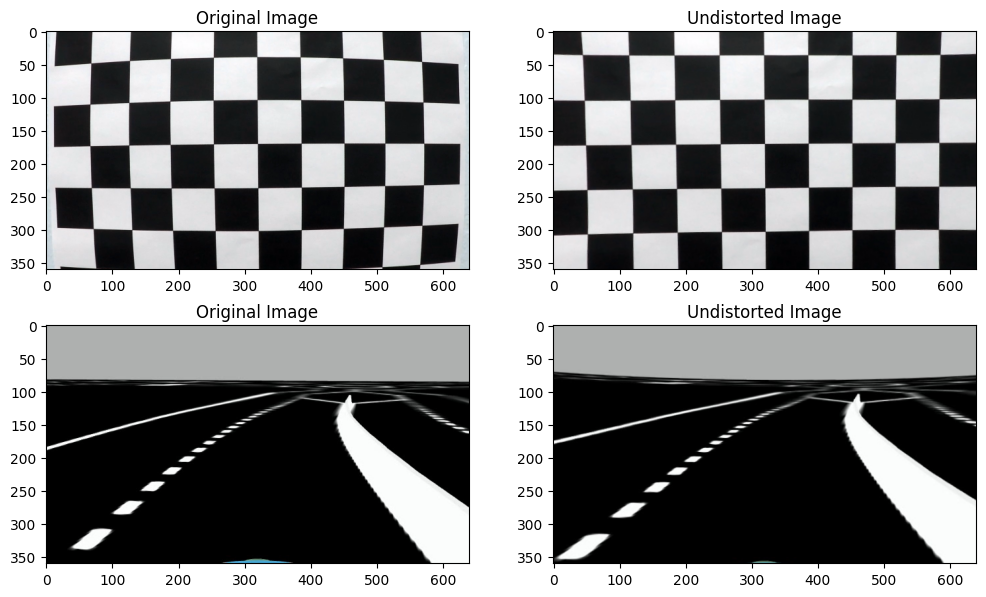

In [171]:
camera = Camera()

# Calibrating for the given camera
mtx, dist = camera.calibrate_camera(cal_images)

img = cv2.imread('camera_cal/calibration1.jpg')
img = cv2.resize(img,IMG_SIZE)
plt.figure(figsize=(12, 7))
plt.subplot(2, 2, 1)
plt.imshow(img)
plt.title("Original Image")
plt.subplot(2, 2, 2)
plt.imshow(cv2.undistort(img,mtx,dist,None,mtx))
plt.title("Undistorted Image")
img = cv2.imread('images/test_images/frame_0.jpg')
img =cv2.resize(img,IMG_SIZE)
plt.subplot(2, 2, 3)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.subplot(2, 2, 4)
plt.imshow(cv2.cvtColor(cv2.undistort(img,mtx,dist,None,mtx), cv2.COLOR_BGR2RGB))
plt.title("Undistorted Image")
plt.savefig("output_images/undist_img.jpg")

### Image Thresholding
In this code chunk are filters for performing thresholding through various techniques, including s-channel colour filtering and sobel thresholding.

[[ 190.  720.]
 [ 582.  457.]
 [ 701.  457.]
 [1145.  720.]]
[[340. 720.]
 [340.   0.]
 [995.   0.]
 [995. 720.]]

In [138]:
src = np.float32([[0, 360], [300, 150], [450, 150], [600, 360]])
dst = np.float32([[50,360],[50,0],[500,0],[500,360]])

In [139]:
src = np.float32([[95, 360], [291, 228], [350, 228], [572, 360]])
offset = [75,0]
dst = np.float32([src[0] + offset, np.array([src[0, 0], 0]) + offset, 
                      np.array([src[3, 0], 0]) - offset, src[3] - offset])
dst

array([[170., 360.],
       [170.,   0.],
       [497.,   0.],
       [497., 360.]], dtype=float32)

In [283]:
def pers_transform(img, nx=9, ny=6):
    # Grab the image shape
    img_size = (img.shape[1], img.shape[0])
    # src = np.float32([[190, 720], [582, 457], [701, 457], [1145, 720]])
    # offset = [150,0]
    # dst = np.float32([src[0] + offset, np.array([src[0, 0], 0]) + offset, 
    #                   np.array([src[3, 0], 0]) - offset, src[3] - offset])

    # src = np.float32([[95, 360], [291, 228], [350, 228], [572, 360]])
    # offset = [75,0]
    # dst = np.float32([src[0] + offset, np.array([src[0, 0], 0]) + offset, 
    #                     np.array([src[3, 0], 0]) - offset, src[3] - offset])

    # project1
    # src = np.float32([[0, 360], [300, 150], [450, 150], [600, 360]])
    # dst = np.float32([[50,360],[50,0],[500,0],[500,360]])
    # project2
    src = np.float32([[20, 300], [50, 180], [400, 180], [600, 300]])
    
    dst = np.float32([[50,360],[50,0],[500,0],[500,360]])
    offset = [75,0]
    dst = np.float32([src[0] + offset, np.array([src[0, 0], 0]) + offset, 
                        np.array([src[3, 0], 0]) - offset, src[3] - offset])
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)
    # Return the resulting image and matrix
    Minv = cv2.getPerspectiveTransform(dst, src)

    return warped, M, Minv


def hls_thresh(img, thresh_min=200, thresh_max=255):
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,1]
    
    # Creating image masked in S channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= thresh_min) & (s_channel <= thresh_max)] = 1
    return s_binary


def sobel_thresh(img, sobel_kernel=3, orient='x', thresh_min=20, thresh_max=100):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel) # Take the derivative in x
        abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    else:
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel) # Take the derivative in x
        abs_sobely = np.absolute(sobely) # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobel = np.uint8(255*abs_sobely/np.max(abs_sobely))
    
    # Creathing img masked in x gradient
    grad_bin = np.zeros_like(scaled_sobel)
    grad_bin[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return grad_bin


def mag_thresh(img, sobel_kernel=3, thresh_min=100, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh_min) & (gradmag <= thresh_max)] = 1

    # Return the binary image
    return binary_output


def dir_thresh(img, sobel_kernel=3, thresh_min=0, thresh_max=np.pi/2):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh_min) & (absgraddir <= thresh_max)] = 1

    # Return the binary image
    return binary_output


def lab_b_channel(img, thresh=(190,255)):
    # Normalises and thresholds to the B channel
    # Convert to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    lab_b = lab[:,:,2]
    # Don't normalize if there are no yellows in the image
    if np.max(lab_b) > 175:
        lab_b = lab_b*(255/np.max(lab_b))
    #  Apply a threshold
    binary_output = np.zeros_like(lab_b)
    binary_output[((lab_b > thresh[0]) & (lab_b <= thresh[1]))] = 1
    return binary_output
    

### Masking the Region of Interest

In [284]:
def mask_image(image):
    masked_image = np.copy(image)
    mask = np.zeros_like(masked_image)
    vertices = np.array([[source[1], source[0], source[2], source[3]]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, [255,255,255])
    masked_edges = cv2.bitwise_and(masked_image, mask)
    return masked_edges

In [285]:
src = np.float32([[190, 720], [582, 457], [701, 457], [1145, 720]])
offset = [150,0]
dst = np.float32([src[0] + offset, np.array([src[0, 0], 0]) + offset, 
                  np.array([src[3, 0], 0]) - offset, src[3] - offset])
print(src)
print(dst)

[[ 190.  720.]
 [ 582.  457.]
 [ 701.  457.]
 [1145.  720.]]
[[340. 720.]
 [340.   0.]
 [995.   0.]
 [995. 720.]]


In [286]:
src = np.float32([[20, 300], [50, 180], [400, 180], [600, 360]])

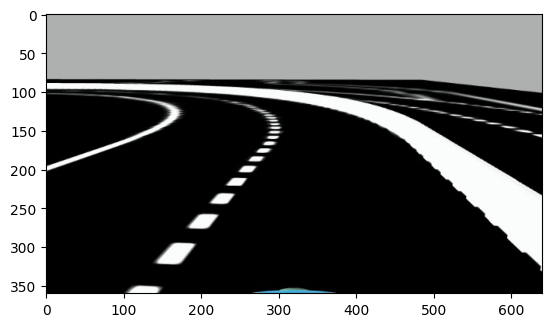

In [287]:
plt.imshow(test_images[5])

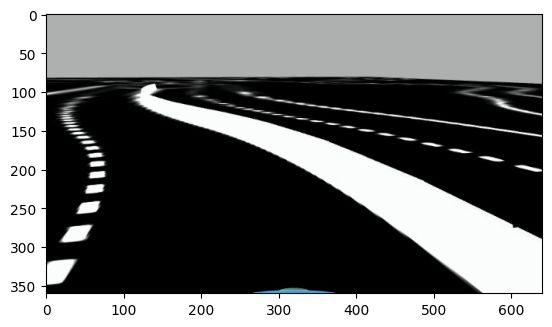

In [288]:
plt.imshow(test_images[0])

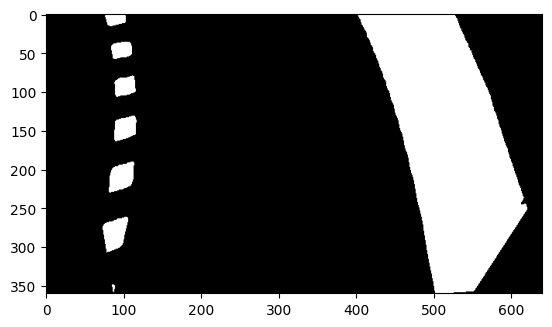

In [289]:
plt.imshow(test_images_thresholded[0],cmap="gray")

In [290]:
def test_process(img):
      
    # Undistorting image
    undist = camera.undistort(img)
    
    # Masking image
    masked = mask_image(undist)
    
    # Perspective transform image
    warped, M, Minv = pers_transform(undist)
    
    # Colour thresholding in S channel
    s_bin = hls_thresh(warped)
    
    # Colour thresholding in B channel of LAB
    b_bin = lab_b_channel(warped, thresh = (185, 255))
    
    # Gradient thresholding with sobel x
    x_bin = sobel_thresh(warped, orient='x', thresh_min=20, thresh_max=100)
    
    # Gradient thresholding with sobel y
    y_bin = sobel_thresh(warped, orient='y', thresh_min=50, thresh_max=150)
    
    # Magnitude of gradient thresholding
    mag_bin = mag_thresh(warped, thresh_min=0, thresh_max=255)
    
    # Direction of gradient thresholding
    dir_bin = dir_thresh(warped, thresh_min=0, thresh_max=np.pi/2)
    
    # Combining both thresholds
    combined = np.zeros_like(x_bin)
    combined[(s_bin==1) | (b_bin == 1)] = 1
    
    return combined, warped, Minv

## Warping and Processing Check

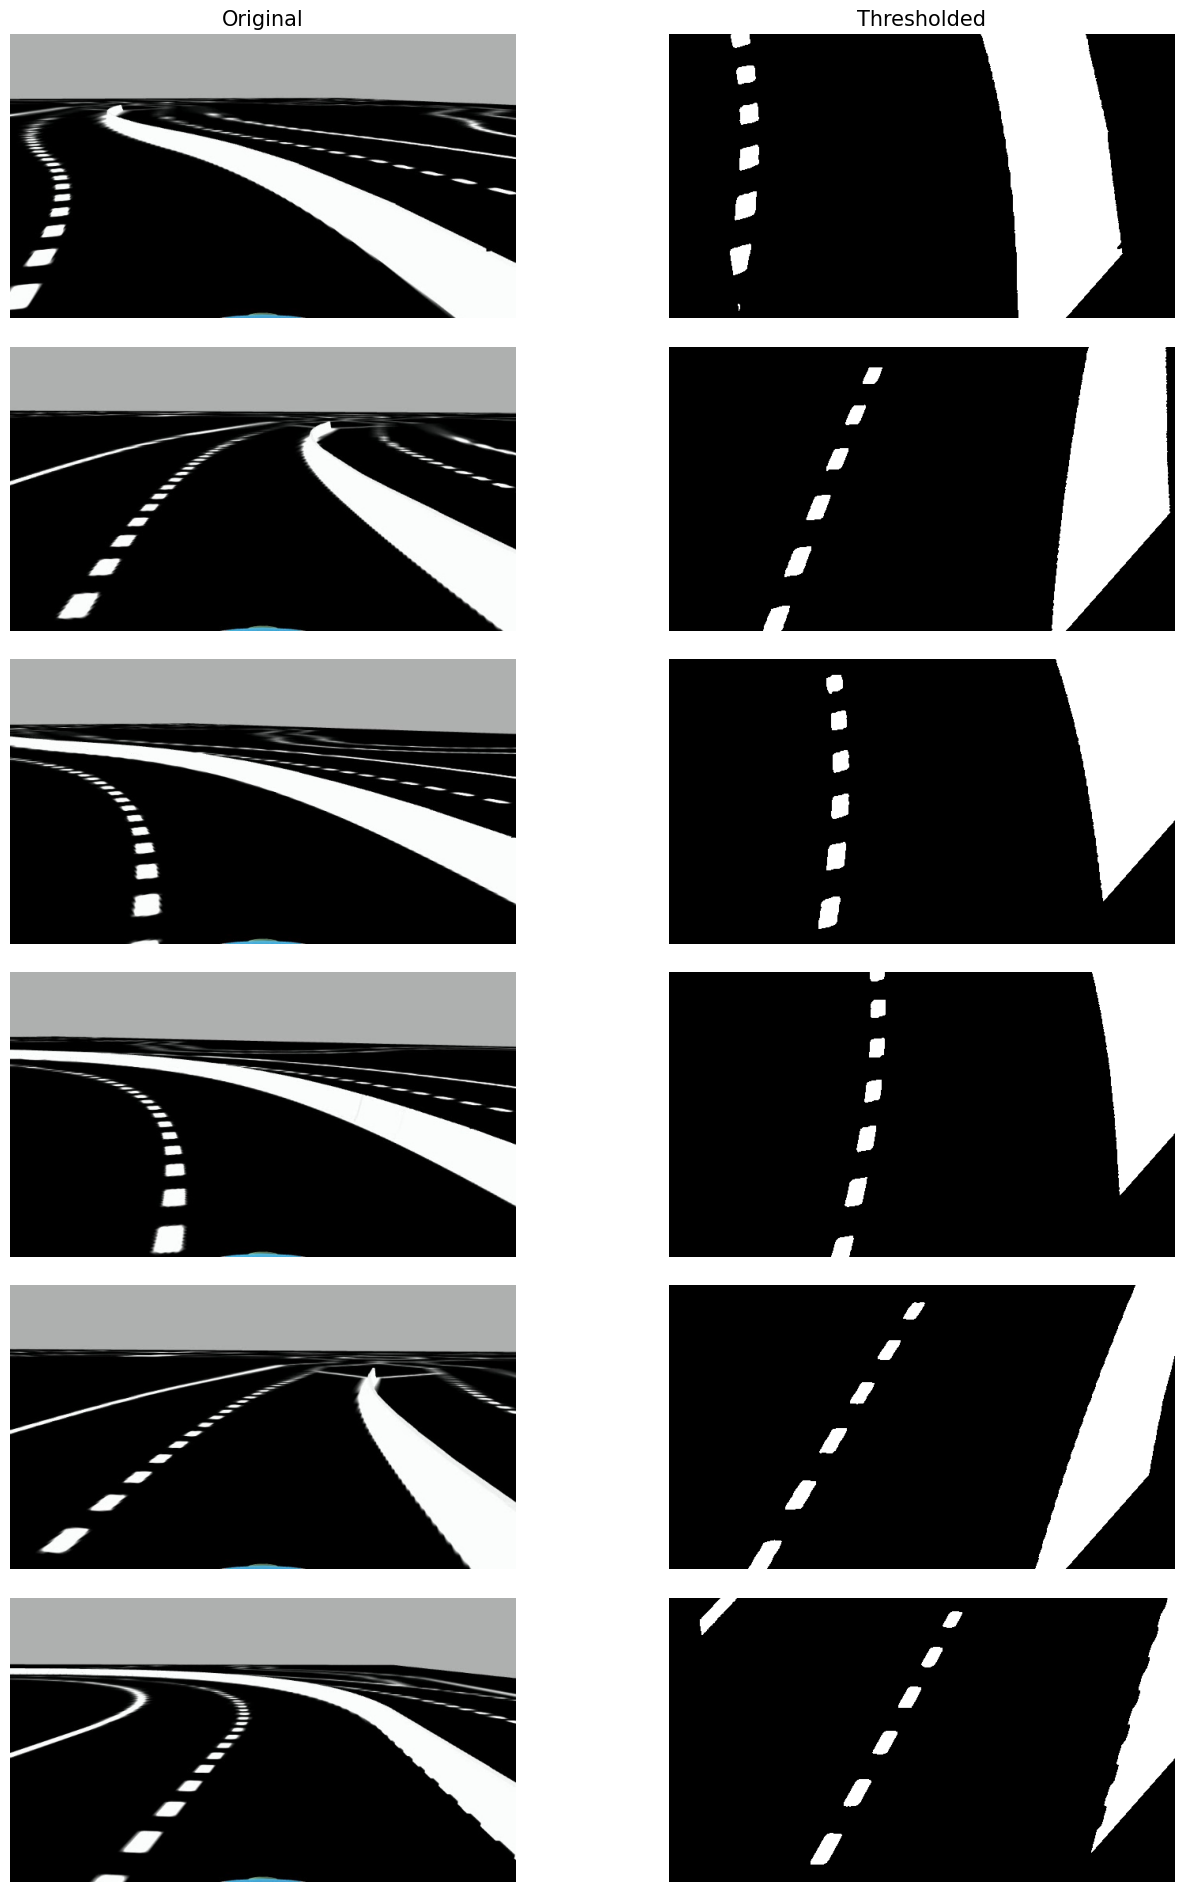

In [291]:
test_images_thresholded= []

fig, ax = plt.subplots(6, 2, figsize=(17,24))
fig.subplots_adjust(hspace=0.1, wspace=0)
ax[0][0].set_title('Original', fontsize=15)
ax[0][1].set_title('Thresholded', fontsize=15)

for i in range(6) :
    ax[i,0].imshow(test_images[i])
    thresholded_img, warped, Minv = test_process(test_images[i])
    test_images_thresholded.append(thresholded_img)
    ax[i,1].imshow(thresholded_img,cmap='gray')
for axes in ax.flatten() :
    axes.axis('off')
plt.savefig("output_images/warp_processing_check.jpg")

## Window Searching
Sliding window search to find lane lines.

In [292]:
def window_search(binary_warped):
    # Take a histogram of the bottom half of the image
    bottom_half_y = binary_warped.shape[0]/2
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Generate black image and colour lane lines
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [1, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 1]
        
    # Draw polyline on image
    right = np.asarray(tuple(zip(right_fitx, ploty)), np.int32)
    left = np.asarray(tuple(zip(left_fitx, ploty)), np.int32)
    cv2.polylines(out_img, [right], False, (1,1,0), thickness=5)
    cv2.polylines(out_img, [left], False, (1,1,0), thickness=5)
    
    return left_lane_inds, right_lane_inds, out_img


### Margin Search
Performs a margin search, a faster derivative of window search that looks in a neighbourhood of the previous lane line.

In [293]:
def margin_search(binary_warped):
    # Performs window search on subsequent frame, given previous frame.
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 30

    left_lane_inds = ((nonzerox > (left_line.current_fit[0]*(nonzeroy**2) + left_line.current_fit[1]*nonzeroy + left_line.current_fit[2] - margin)) & (nonzerox < (left_line.current_fit[0]*(nonzeroy**2) + left_line.current_fit[1]*nonzeroy + left_line.current_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_line.current_fit[0]*(nonzeroy**2) + right_line.current_fit[1]*nonzeroy + right_line.current_fit[2] - margin)) & (nonzerox < (right_line.current_fit[0]*(nonzeroy**2) + right_line.current_fit[1]*nonzeroy + right_line.current_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Generate a blank image to draw on
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Create an image to draw on and an image to show the selection window
    window_img = np.zeros_like(out_img)

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.intc([left_line_pts]), (0,255,0))
    cv2.fillPoly(window_img, np.intc([right_line_pts]), (0,255,0))
    out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [1, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 1]
        
    # Draw polyline on image
    right = np.asarray(tuple(zip(right_fitx, ploty)), np.int32)
    left = np.asarray(tuple(zip(left_fitx, ploty)), np.int32)
    cv2.polylines(out_img, [right], False, (1,1,0), thickness=5)
    cv2.polylines(out_img, [left], False, (1,1,0), thickness=5)
    
    return left_lane_inds, right_lane_inds, out_img

### Window Search Check

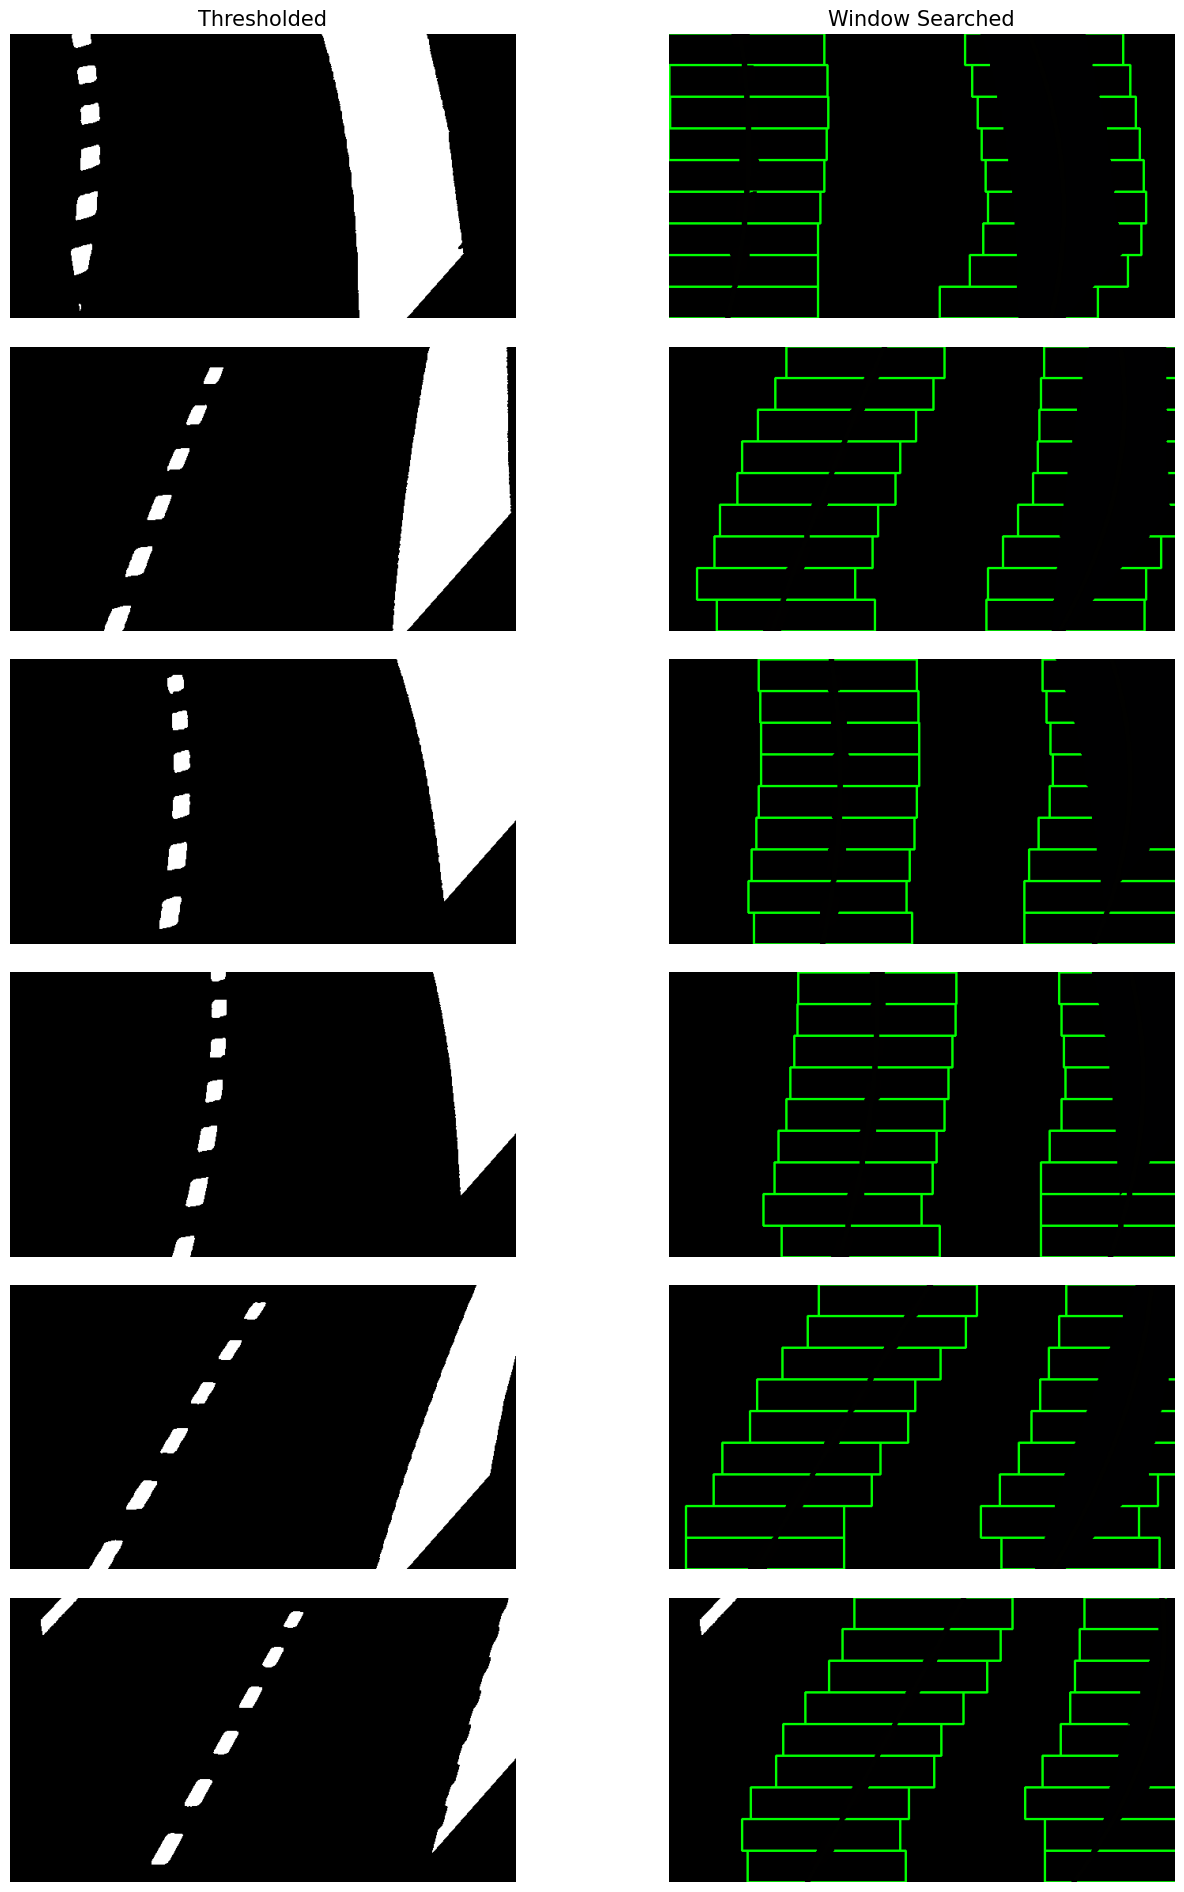

In [294]:
fig, ax = plt.subplots(6, 2, figsize=(17,24))
fig.subplots_adjust(hspace=0.1, wspace=0)
ax[0][0].set_title('Thresholded', fontsize=15)
ax[0][1].set_title('Window Searched', fontsize=15)

for i in range(6) :
    thresholded_img, warped, Minv = test_process(test_images[i])
    ax[i,0].imshow(thresholded_img, cmap='gray')
    left, right, polynom_img = window_search(thresholded_img)
    ax[i,1].imshow(polynom_img)
for axes in ax.flatten() :
    axes.axis('off')
plt.savefig("output_images/polynom_windows.jpg")

### Line Class
Just a line class for storing information about the lane lines, as well as a method for updating that information.

In [295]:
class Line():
    def __init__(self, maxSamples=4):
        
        self.maxSamples = maxSamples 
        # x values of the last n fits of the line
        self.recent_xfitted = deque(maxlen=self.maxSamples)
        # Polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        # Polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        # Average x values of the fitted line over the last n iterations
        self.bestx = None
        # Was the line detected in the last iteration?
        self.detected = False 
        # Radius of curvature of the line in some units
        self.radius_of_curvature = None 
        # Distance in meters of vehicle center from the line
        self.line_base_pos = None 
         
    def update_lane(self, ally, allx):
        # Updates lanes on every new frame
        # Mean x value 
        self.bestx = np.mean(allx, axis=0)
        # Fit 2nd order polynomial
        new_fit = np.polyfit(ally, allx, 2)
        # Update current fit3
        self.current_fit = new_fit
        # Add the new fit to the queue
        self.recent_xfitted.append(self.current_fit)
        # Use the queue mean as the best fit
        self.best_fit = np.mean(self.recent_xfitted, axis=0)
        # meters per pixel in y dimension
        ym_per_pix = 30/720
        # meters per pixel in x dimension
        xm_per_pix = 3.7/700
        # Calculate radius of curvature
        fit_cr = np.polyfit(ally*ym_per_pix, allx*xm_per_pix, 2)
        y_eval = np.max(ally)
        self.radius_of_curvature = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])

### Lane Validation
Checks if the detected lane is good enough to use as a reliable frame (number of points).
If passed, updates the Line() class with the new lane polynomial.

In [296]:
def validate_lane_update(img, left_lane_inds, right_lane_inds):
    # Checks if detected lanes are good enough before updating
    img_size = (img.shape[1], img.shape[0])
    
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Extract left and right line pixel positions
    left_line_allx = nonzerox[left_lane_inds]
    left_line_ally = nonzeroy[left_lane_inds] 
    right_line_allx = nonzerox[right_lane_inds]
    right_line_ally = nonzeroy[right_lane_inds]
    
    # Discard lane detections that have very little points, 
    # as they tend to have unstable results in most cases
    if len(left_line_allx) <= 900 or len(right_line_allx) <= 900:
        left_line.detected = False
        right_line.detected = False
        return
    
    left_x_mean = np.mean(left_line_allx, axis=0)
    right_x_mean = np.mean(right_line_allx, axis=0)
    lane_width = np.subtract(right_x_mean, left_x_mean)
    
    # Discard the detections if lanes are not in their repective half of their screens
    if left_x_mean > 370 or right_x_mean < 370:
        left_line.detected = False
        right_line.detected = False
        return
    
    # Discard the detections if the lane width is too large or too small
    if  lane_width < 150 or lane_width > 400:
        left_line.detected = False
        right_line.detected = False
        return 
    
    # If this is the first detection or 
    # the detection is within the margin of the averaged n last lines 
    if left_line.bestx is None or np.abs(np.subtract(left_line.bestx, np.mean(left_line_allx, axis=0))) < 100:
        left_line.update_lane(left_line_ally, left_line_allx)
        left_line.detected = True
    else:
        left_line.detected = False
    if right_line.bestx is None or np.abs(np.subtract(right_line.bestx, np.mean(right_line_allx, axis=0))) < 100:
        right_line.update_lane(right_line_ally, right_line_allx)
        right_line.detected = True
    else:
        right_line.detected = False    
 
    # Calculate vehicle-lane offset
    xm_per_pix = 3.7/610 # meters per pixel in x dimension, lane width is 12 ft = 3.7 meters
    car_position = img_size[0]/2
    l_fit = left_line.current_fit
    r_fit = right_line.current_fit
    left_lane_base_pos = l_fit[0]*img_size[1]**2 + l_fit[1]*img_size[1] + l_fit[2]
    right_lane_base_pos = r_fit[0]*img_size[1]**2 + r_fit[1]*img_size[1] + r_fit[2]
    lane_center_position = (left_lane_base_pos + right_lane_base_pos) /2
    left_line.line_base_pos = (car_position - lane_center_position) * xm_per_pix +0.2
    right_line.line_base_pos = left_line.line_base_pos

### Lane Drawing and Stats
Function find_lanes performs a margin search if a previous lane had been found. Otherwise, it performs a fresh window_search.
write_stats simply renders stats about lane curvature and vehicle offset.
draw_lane draws the lane overlay onto the warped image, and warps it back into its original perspective (dashcam)

In [297]:
def find_lanes(img):
    if left_line.detected and right_line.detected:  # Perform margin search if exists prior success.
        # Margin Search
        left_lane_inds, right_lane_inds,out_img = margin_search(img)
        # Update the lane detections
        validate_lane_update(img, left_lane_inds, right_lane_inds)
        
    else:  # Perform a full window search if no prior successful detections.
        # Window Search
        print("ngoo")
        left_lane_inds, right_lane_inds,out_img = window_search(img)
        # Update the lane detections
        validate_lane_update(img, left_lane_inds, right_lane_inds)
    return out_img


def write_stats(img):
    font = cv2.FONT_HERSHEY_PLAIN
    size = 3
    weight = 2
    color = (255,255,255)
    
    radius_of_curvature = (right_line.radius_of_curvature + right_line.radius_of_curvature)/2
    cv2.putText(img,'Lane Curvature Radius: '+ '{0:.2f}'.format(radius_of_curvature)+'m',(15,30), font, size, color, weight)

    if (left_line.line_base_pos >=0):
        cv2.putText(img,'Vehicle is '+ '{0:.2f}'.format(left_line.line_base_pos*100)+'cm'+ ' Right of Center',(15,50), font, size, color, weight)
    else:
        cv2.putText(img,'Vehicle is '+ '{0:.2f}'.format(abs(left_line.line_base_pos)*100)+'cm' + ' Left of Center',(15,50), font, size, color, weight)
        
        
def draw_lane(undist, img, Minv):
    # Generate x and y values for plotting
    ploty = np.linspace(0, undist.shape[0] - 1, undist.shape[0])
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(img).astype(np.uint8)
    color_warp = np.stack((warp_zero, warp_zero, warp_zero), axis=-1)

    left_fit = left_line.best_fit
    right_fit = right_line.best_fit
    print(right_fit)
    if left_fit is not None and right_fit is not None:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))
        
        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (64, 224, 208))
        
        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
        
        # Combine the result with the original image
        result = cv2.addWeighted(undist, 1, newwarp, 0.6, 0)
        write_stats(result)
        return result
    return undist

In [298]:
def assemble_img(warped, threshold_img, polynomial_img, lane_img):
    # Define output image
    # Main image
    img_out=np.zeros((360,854,3), dtype=np.uint8)
    # img_out[0:720,0:1280,:] = lane_img
    img_out[0:360,0:640,:] = lane_img
    
    # Text formatting
    fontScale=1
    thickness=1
    fontFace = cv2.FONT_HERSHEY_PLAIN
    
    # Perspective transform image
    img_out[0:120,641:854,:] = cv2.resize(warped,(213,120))
    boxsize, _ = cv2.getTextSize("Transformed", fontFace, fontScale, thickness)
    cv2.putText(img_out, "Transformed", (int(747-boxsize[0]/2),40), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
   
    # Threshold image
    resized = cv2.resize(threshold_img,(213,120))
    resized=np.uint8(resized)
    gray_image = cv2.cvtColor(resized*255,cv2.COLOR_GRAY2RGB)
    img_out[121:241,641:854,:] = cv2.resize(gray_image,(213,120))
    boxsize, _ = cv2.getTextSize("Filtered", fontFace, fontScale, thickness)
    cv2.putText(img_out, "Filtered", (int(747-boxsize[0]/2),141), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
 
    # Polynomial lines
    img_out[240:360,641:854,:] = cv2.resize(polynomial_img*255,(213,120))
    boxsize, _ = cv2.getTextSize("Detected Lanes", fontFace, fontScale, thickness)
    cv2.putText(img_out, "Detected Lanes", (int(747-boxsize[0]/2),523621), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    
    return img_out

## Final Pipeline

In [299]:
def process_img(img):
    img =cv2.resize(img,IMG_SIZE)
    # Undistorting image
    undist = camera.undistort(img)
    # Masking image
    masked = mask_image(undist)
    
    # Perspective transform image
    warped, M, Minv = pers_transform(undist)
    
    # Colour thresholding in S channel
    s_bin = hls_thresh(warped)
    
    # Colour thresholding in B channel of LAB
    b_bin = lab_b_channel(warped, thresh = (185, 255))
    
    # Combining both thresholds
    combined = np.zeros_like(s_bin)
    combined[(s_bin==1) | (b_bin == 1)] = 1
    
    # Find Lanes
    output_img = find_lanes(combined)

    # Draw lanes on image
    lane_img = draw_lane(undist, combined, Minv); 
    
    result = assemble_img(warped, combined, output_img, lane_img)    
    
    return result

ngoo
[-7.11132230e-04 -9.32070454e-02  6.10644216e+02]
...


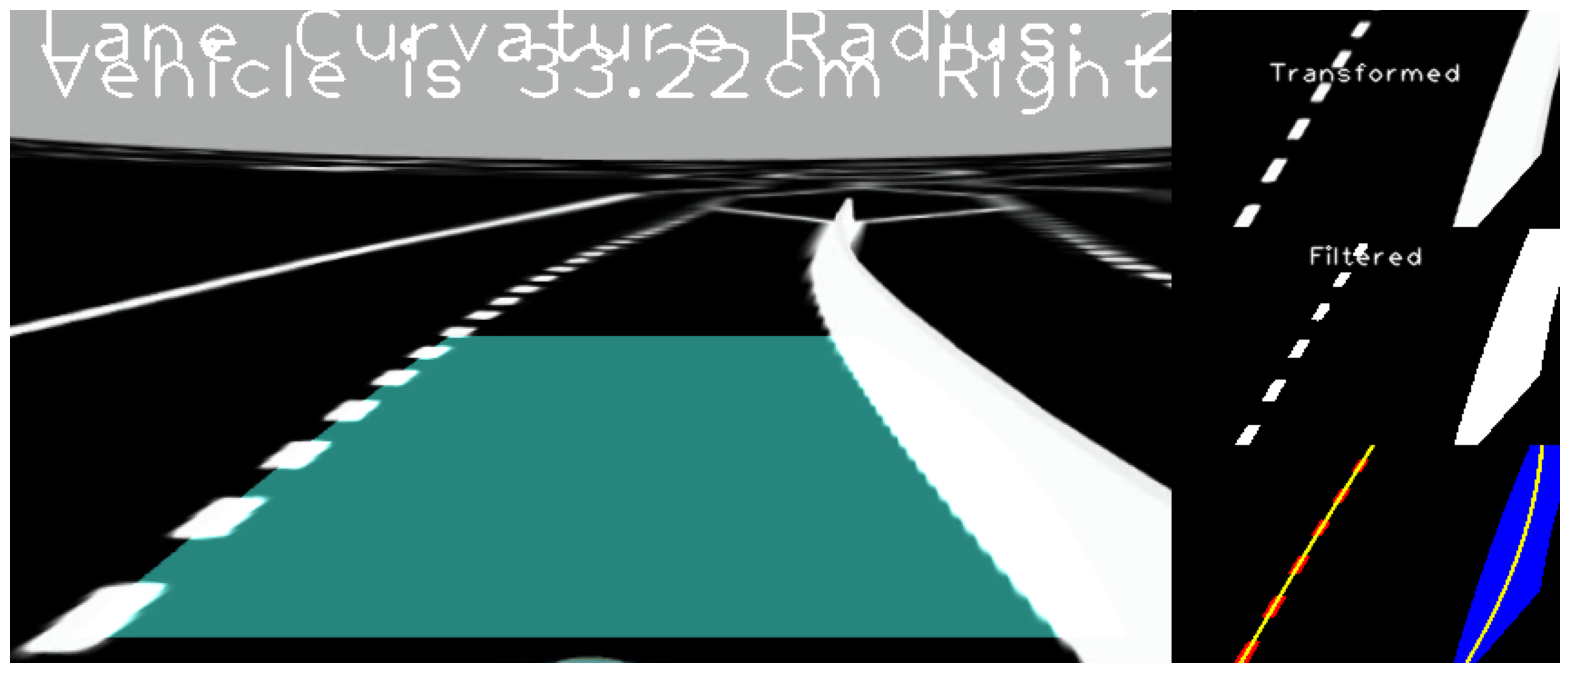

In [305]:
left_line = Line()
right_line = Line()

plt.figure(figsize = (20,20))
plt.imshow(process_img(test_images[4]))
plt.axis('off')
print ("...")
plt.savefig("output_images/assembled_img.jpg")

In [227]:
left_line = Line()
right_line = Line()

undist = camera.undistort(test_images[2])
    # Masking image
masked = mask_image(undist)

# Perspective transform image
warped, M, Minv = pers_transform(undist)
s_bin = hls_thresh(warped)
    
    # Colour thresholding in B channel of LAB
b_bin = lab_b_channel(warped, thresh = (185, 255))
combined = np.zeros_like(s_bin)
combined[(s_bin==1) | (b_bin == 1)] = 1
output_img = find_lanes(combined)
lane_img = draw_lane(undist, combined, Minv); 
plt.figure(figsize = (20,20))
# plt.imshow(process_img(test_images[2]))
plt.imshow(process_img("/Users/namle/BachKhoa/HK232/DOAN/Advanced-Lane-Lines/image.png"))
# plt.imshow(lane_img)
plt.axis('off')
print ("...")
# plt.savefig("output_images/assembled_img.jpg")

ngoo
[-4.77083854e-04  3.02471253e-01  5.64427940e+02]


error: OpenCV(4.9.0) :-1: error: (-5:Bad argument) in function 'resize'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'


<Figure size 2000x2000 with 0 Axes>

In [219]:
import pygame
video = VideoFileClip("/Users/namle/BachKhoa/HK232/DOAN/Advanced-Lane-Lines/camera_front_view.mp4")

In [214]:
# Initialize Left and Right Lanes
left_line = Line()
right_line = Line()
# Reset and Calibrate
project_clip = VideoFileClip("/Users/namle/BachKhoa/HK232/DOAN/Advanced-Lane-Lines/camera_front_view.mp4")
video_result = 'test.mp4'
project_video_clip = project_clip.fl_image(process_img)
project_video_clip.write_videofile(video_result, audio=False)

Moviepy - Building video test.mp4.
Moviepy - Writing video test.mp4



t:  10%|█         | 133/1292 [00:02<00:16, 69.67it/s, now=None]

TypeError: expected non-empty vector for x

t:  11%|█         | 140/1292 [00:17<00:16, 69.67it/s, now=None]

In [28]:
import uuid
import os
import time
video = cv2.VideoCapture("/Users/namle/BachKhoa/HK232/DOAN/Advanced-Lane-Lines/camera_front_view.mp4")
# video.set(cv2.CAP_PROP_FPS, 10)
# IMAGE_PATH = "/Users/namle/BachKhoa/HK232/DOAN/Advanced-Lane-Lines/images"
img_path = "/Users/namle/BachKhoa/HK232/DOAN/Advanced-Lane-Lines/images"
# img_path = os.path.join(IMAGE_PATH, "test_img")
# os.makedirs(img_path)
test_img = []
frame_count = 0
count =0
framerate = video.get(cv2.CAP_PROP_FPS)
while (video.isOpened()):

    frame_count += 1
    flag, img = video.read()
    img_real = np.copy(img)
    if not flag: break
    b, g, r = cv2.split(img)
    img = cv2.merge([r, g, b])
    if frame_count == (framerate * 10):
        frame_count =0
        count += 1
        cv2.imshow("Video", img)
        # img_name = os.path.join(img_path,"test_img","test_img"+'.'+'{}.jpg'.format(str(uuid.uuid1())))
        img_name = os.path.join(img_path,"test_images", f"frame_{count}.jpg")
        test_img.append(img)
        cv2.imwrite(img_name,img)
        
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break



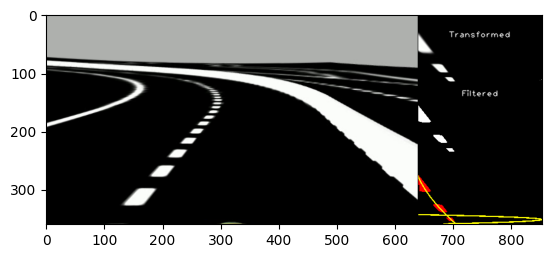

In [58]:
left_line = Line()
right_line = Line()
plt.imshow(process_img(test_img[0]))

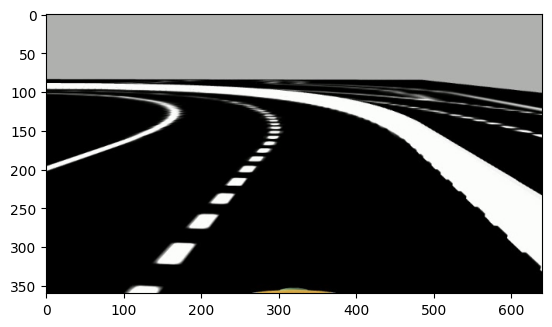

In [57]:

img = cv2.imread("/Users/namle/BachKhoa/HK232/DOAN/Advanced-Lane-Lines/images/test_images/frame_1.jpg")
img = cv2.resize(img,IMG_SIZE)
plt.imshow(img)

In [27]:
len(test_img)

1292

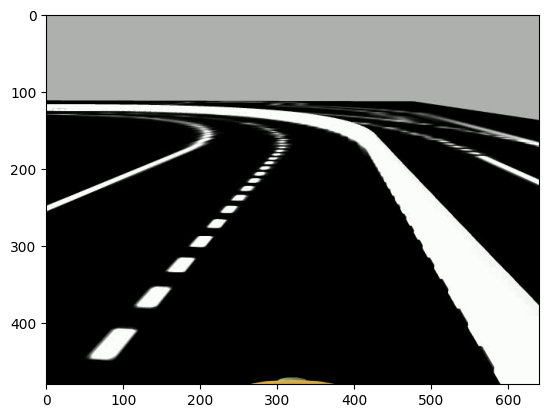

In [25]:
plt.imshow(test_img[0])

In [226]:
print(len(test_img))

1292


In [ ]:
video = cv2.VideoCapture("/Users/namle/BachKhoa/HK232/DOAN/Advanced-Lane-Lines/camera_front_view.mp4")
video.set(cv2.CAP_PROP_FPS, 10)

while (video.isOpened()):
    try:
        flag, img = video.read()
        # print(img.shape)
        img = cv2.resize(img, IMG_SIZE)
        img_real = np.copy(img)
        if not flag: break
        b, g, r = cv2.split(img)
        img = cv2.merge([r, g, b])
        out_img = np.copy(img)
        img = calibration.undistort(img)
        img = transform.forward(img)
        bird_eye_img = np.copy(img)
        img = thresholding.forward(img)
        img = lanelines.forward(img)
        img = transform.backward(img)
        out_img = cv2.addWeighted(out_img, 1, img, 0.6, 0)
        # out_img = lanelines.plot(out_img)

        # combined_img = np.hstack((out_img, img_real,bird_eye_img))
        # cv2.imshow("Combined Images", combined_img)
        cv2.imshow("Combined Images", out_img)
        if cv2.waitKey(1) == ord('q'):break
    except Exception as e:
        print(e)

In [306]:
project_clip = VideoFileClip("/Users/namle/BachKhoa/HK232/DOAN/Advanced-Lane-Lines/camera_front_view.mp4")

In [307]:
# Initialize Left and Right Lanes
left_line = Line()
right_line = Line()
# Reset and Calibrate
video_result = 'project_clip2_result.mp4'
project_video_clip = project_clip.fl_image(process_img)
project_video_clip.write_videofile(video_result, audio=False)

ngoo
[-6.87014633e-04 -9.66360146e-02  6.13534432e+02]
Moviepy - Building video project_clip2_result.mp4.
Moviepy - Writing video project_clip2_result.mp4



t:   0%|          | 0/1292 [00:00<?, ?it/s, now=None]

[-7.03815936e-04 -9.45167328e-02  6.13748979e+02]


t:   0%|          | 3/1292 [00:00<00:59, 21.55it/s, now=None]

[-6.10949336e-04 -1.25264150e-01  6.16959439e+02]
[-5.73465493e-04 -1.36892065e-01  6.18593020e+02]
[-5.29371283e-04 -1.51258568e-01  6.20952068e+02]


t:   0%|          | 6/1292 [00:00<01:01, 20.95it/s, now=None]

[-4.85859961e-04 -1.63546898e-01  6.23117566e+02]
[-5.23619002e-04 -1.49675076e-01  6.22846831e+02]


t:   1%|          | 9/1292 [00:00<00:57, 22.33it/s, now=None]

[-5.57919209e-04 -1.37646489e-01  6.22495163e+02]
[-5.84710392e-04 -1.28355752e-01  6.22226119e+02]
[-6.06742509e-04 -1.20732726e-01  6.22000156e+02]


t:   1%|          | 12/1292 [00:00<00:58, 21.93it/s, now=None]

[-6.25261086e-04 -1.14321710e-01  6.21814481e+02]
[-6.41855843e-04 -1.08569048e-01  6.21643780e+02]


t:   1%|          | 15/1292 [00:00<00:59, 21.49it/s, now=None]

[-6.56446360e-04 -1.03477666e-01  6.21489687e+02]
[-6.69474574e-04 -9.88816268e-02  6.21341021e+02]
[-6.81148814e-04 -9.47445301e-02  6.21205795e+02]
[-6.91714543e-04 -9.09920212e-02  6.21081377e+02]
[-7.00702469e-04 -8.78171465e-02  6.20985786e+02]


t:   1%|▏         | 18/1292 [00:00<01:00, 20.95it/s, now=None]

[-7.09492589e-04 -8.47610048e-02  6.20894005e+02]
[-7.17076483e-04 -8.21217943e-02  6.20817855e+02]
[-7.23000973e-04 -8.00478387e-02  6.20772196e+02]


t:   2%|▏         | 21/1292 [00:00<00:59, 21.37it/s, now=None]

[-7.30432443e-04 -7.74312068e-02  6.20674462e+02]
[-7.35855682e-04 -7.55026570e-02  6.20613142e+02]


t:   2%|▏         | 24/1292 [00:01<01:02, 20.30it/s, now=None]

[-7.40543298e-04 -7.38518110e-02  6.20569350e+02]
[-7.46128618e-04 -7.19055218e-02  6.20490375e+02]
[-7.49802773e-04 -7.06347801e-02  6.20460134e+02]
[-7.53076527e-04 -6.95262280e-02  6.20441664e+02]
[-7.57027350e-04 -6.81792874e-02  6.20391222e+02]


t:   2%|▏         | 30/1292 [00:01<00:54, 23.33it/s, now=None]

[-7.60135198e-04 -6.71219482e-02  6.20361268e+02]
[-7.61977348e-04 -6.64731954e-02  6.20355821e+02]
[-7.65540792e-04 -6.51980845e-02  6.20296699e+02]
[-7.68206746e-04 -6.42383111e-02  6.20263965e+02]
[-7.70677128e-04 -6.33402524e-02  6.20232503e+02]


t:   3%|▎         | 33/1292 [00:01<00:55, 22.78it/s, now=None]

[-7.73678381e-04 -6.22711124e-02  6.20183221e+02]
[-7.75160983e-04 -6.17337251e-02  6.20167352e+02]
[-7.75910496e-04 -6.14411446e-02  6.20163691e+02]


t:   3%|▎         | 36/1292 [00:01<00:53, 23.42it/s, now=None]

[-7.73683736e-04 -6.21929782e-02  6.20240597e+02]
[-7.71022199e-04 -6.30445588e-02  6.20316941e+02]
[-7.66506225e-04 -6.45468152e-02  6.20447142e+02]


t:   3%|▎         | 39/1292 [00:01<00:51, 24.27it/s, now=None]

[-7.60448698e-04 -6.65503748e-02  6.20619721e+02]
[-7.57017839e-04 -6.76032890e-02  6.20712606e+02]
[-7.51464918e-04 -6.94505157e-02  6.20885829e+02]


t:   3%|▎         | 42/1292 [00:01<00:50, 24.92it/s, now=None]

[-7.48652511e-04 -7.03277181e-02  6.20993669e+02]
[-7.46282775e-04 -7.10299857e-02  6.21101843e+02]


t:   3%|▎         | 45/1292 [00:02<00:58, 21.26it/s, now=None]

[-7.43682922e-04 -7.18098217e-02  6.21234659e+02]
[-7.43436674e-04 -7.17680055e-02  6.21320818e+02]


t:   4%|▎         | 48/1292 [00:02<00:55, 22.53it/s, now=None]

[-7.42958849e-04 -7.17365901e-02  6.21421395e+02]
[-7.44521043e-04 -7.09928586e-02  6.21479926e+02]
[-7.46792424e-04 -6.99521707e-02  6.21531979e+02]


t:   4%|▍         | 51/1292 [00:02<00:52, 23.83it/s, now=None]

[-7.48648599e-04 -6.89689696e-02  6.21597082e+02]
[-7.51915826e-04 -6.75312103e-02  6.21634092e+02]
[-7.53121281e-04 -6.68532848e-02  6.21746419e+02]


t:   4%|▍         | 54/1292 [00:02<00:50, 24.73it/s, now=None]

[-7.55750262e-04 -6.56725584e-02  6.21814121e+02]
[-7.57392383e-04 -6.48622427e-02  6.21907643e+02]
[-7.57930336e-04 -6.44552425e-02  6.22021711e+02]


t:   4%|▍         | 57/1292 [00:02<00:48, 25.66it/s, now=None]

[-7.59212658e-04 -6.37720674e-02  6.22099116e+02]
[-7.57386610e-04 -6.42276106e-02  6.22264297e+02]
[-7.58052753e-04 -6.38329903e-02  6.22352076e+02]


t:   5%|▍         | 60/1292 [00:02<00:46, 26.31it/s, now=None]

[-7.56581779e-04 -6.41948861e-02  6.22508466e+02]
[-7.56952948e-04 -6.38454014e-02  6.22588931e+02]
[-7.56872485e-04 -6.36509390e-02  6.22694754e+02]
[-7.58319404e-04 -6.29410347e-02  6.22763633e+02]
[-7.60204324e-04 -6.20343035e-02  6.22833675e+02]


t:   5%|▍         | 63/1292 [00:02<00:50, 24.52it/s, now=None]

[-7.63472744e-04 -6.06910515e-02  6.22889851e+02]
[-7.69759874e-04 -5.82331190e-02  6.22854484e+02]
[-7.74521266e-04 -5.63570467e-02  6.22890318e+02]


t:   5%|▌         | 66/1292 [00:02<00:50, 24.06it/s, now=None]

[-7.80615689e-04 -5.40334019e-02  6.22881052e+02]
[-7.86188754e-04 -5.18015067e-02  6.22873081e+02]


t:   5%|▌         | 69/1292 [00:02<00:51, 23.94it/s, now=None]

[-7.90702318e-04 -5.00159680e-02  6.22911466e+02]
[-7.95361917e-04 -4.81010594e-02  6.22919528e+02]
[-7.98762458e-04 -4.65957199e-02  6.22958585e+02]


t:   6%|▌         | 72/1292 [00:03<00:50, 24.26it/s, now=None]

[-8.00534271e-04 -4.57397174e-02  6.23053769e+02]
[-8.02758829e-04 -4.47478406e-02  6.23131323e+02]


t:   6%|▌         | 75/1292 [00:03<00:49, 24.70it/s, now=None]

[-8.04221827e-04 -4.39492298e-02  6.23205922e+02]
[-8.04802897e-04 -4.34980001e-02  6.23313306e+02]
[-8.05930821e-04 -4.28423770e-02  6.23385600e+02]
[-8.05287495e-04 -4.27673364e-02  6.23489788e+02]


t:   6%|▌         | 78/1292 [00:03<00:48, 24.85it/s, now=None]

[-8.03382619e-04 -4.31844978e-02  6.23637194e+02]
[-8.02761278e-04 -4.31466748e-02  6.23741306e+02]


t:   6%|▋         | 81/1292 [00:03<00:46, 25.85it/s, now=None]

[-8.02165130e-04 -4.31384592e-02  6.23869561e+02]
[-8.01853142e-04 -4.29903908e-02  6.23988522e+02]
[-8.03510515e-04 -4.21165158e-02  6.24064904e+02]
[-8.06316343e-04 -4.08686852e-02  6.24112445e+02]


t:   7%|▋         | 84/1292 [00:03<00:45, 26.33it/s, now=None]

[-8.09502341e-04 -3.94853813e-02  6.24145724e+02]
[-8.13373271e-04 -3.78838287e-02  6.24177005e+02]


t:   7%|▋         | 87/1292 [00:03<00:44, 27.29it/s, now=None]

[-8.18641236e-04 -3.58366827e-02  6.24162880e+02]
[-8.23427509e-04 -3.40033010e-02  6.24179604e+02]
[-8.27645595e-04 -3.23144665e-02  6.24215032e+02]
[-8.32521813e-04 -3.04102361e-02  6.24230166e+02]


t:   7%|▋         | 91/1292 [00:03<00:42, 28.50it/s, now=None]

[-8.36040306e-04 -2.90042086e-02  6.24286641e+02]
[-8.38804458e-04 -2.78250242e-02  6.24369836e+02]
[-8.43393592e-04 -2.60339475e-02  6.24388181e+02]


t:   7%|▋         | 94/1292 [00:03<00:44, 26.91it/s, now=None]

[-8.46146958e-04 -2.48871973e-02  6.24456560e+02]
[-8.48861191e-04 -2.36435289e-02  6.24510291e+02]
[-8.52891124e-04 -2.19014579e-02  6.24499487e+02]
[-8.53371394e-04 -2.14150739e-02  6.24616547e+02]
[-8.57000238e-04 -1.98188451e-02  6.24632997e+02]
[-8.59506259e-04 -1.86924766e-02  6.24696824e+02]


t:   8%|▊         | 98/1292 [00:04<00:42, 28.00it/s, now=None]

[-8.60636863e-04 -1.80070747e-02  6.24798186e+02]
[-8.63898781e-04 -1.65607395e-02  6.24812539e+02]
[-8.65802394e-04 -1.56286971e-02  6.24882214e+02]


t:   8%|▊         | 101/1292 [00:04<00:47, 25.30it/s, now=None]

[-8.67834625e-04 -1.45801276e-02  6.24929954e+02]
[-8.71496978e-04 -1.31119010e-02  6.24960639e+02]


t:   8%|▊         | 104/1292 [00:04<00:46, 25.74it/s, now=None]

[-8.74221718e-04 -1.19092798e-02  6.25022275e+02]
[-8.78245310e-04 -1.02139846e-02  6.25032146e+02]
[-8.83052548e-04 -8.45123426e-03  6.25085953e+02]
[-8.88042958e-04 -6.41459090e-03  6.25085309e+02]


t:   8%|▊         | 108/1292 [00:04<00:43, 27.33it/s, now=None]

[-8.94160291e-04 -4.14420071e-03  6.25068978e+02]
[-8.97439107e-04 -2.86822918e-03  6.25150458e+02]
[-9.01529201e-04 -1.14474202e-03  6.25148030e+02]


t:   9%|▊         | 112/1292 [00:04<00:41, 28.63it/s, now=None]

[-9.04554571e-04  1.57835634e-04  6.25180520e+02]
[-9.05850821e-04  9.09653307e-04  6.25269126e+02]
[-9.09237182e-04  2.42980549e-03  6.25279799e+02]
[-9.10892584e-04  3.35593573e-03  6.25338087e+02]


t:   9%|▉         | 115/1292 [00:04<00:43, 26.79it/s, now=None]

[-9.12048783e-04  4.09187744e-03  6.25414781e+02]
[-9.13256153e-04  4.90548867e-03  6.25475507e+02]


t:   9%|▉         | 118/1292 [00:04<00:43, 27.17it/s, now=None]

[-9.13476299e-04  5.38437317e-03  6.25558566e+02]
[-9.14678291e-04  6.19713492e-03  6.25609717e+02]
[-9.14985339e-04  6.70623685e-03  6.25715598e+02]
[-9.17986639e-04  8.15017890e-03  6.25718784e+02]
[-9.20156457e-04  9.24401346e-03  6.25780506e+02]
[-9.22473904e-04  1.03470064e-02  6.25858146e+02]
[-9.27487901e-04  1.22915354e-02  6.25842142e+02]


t:  10%|▉         | 126/1292 [00:05<00:39, 29.69it/s, now=None]

[-9.30354634e-04  1.34768088e-02  6.25908289e+02]
[-9.35064980e-04  1.53212181e-02  6.25911044e+02]
[-9.39923917e-04  1.71559385e-02  6.25937277e+02]
[-9.44340885e-04  1.88947413e-02  6.25958578e+02]
[-9.49285578e-04  2.07962282e-02  6.26004697e+02]
[-9.54865776e-04  2.28452301e-02  6.26009311e+02]
[-9.59477322e-04  2.46559001e-02  6.26018775e+02]


t:  10%|█         | 130/1292 [00:05<00:38, 30.39it/s, now=None]

[-9.63621251e-04  2.62824562e-02  6.26067731e+02]
[-9.67367040e-04  2.78254519e-02  6.26068455e+02]
[-9.68884736e-04  2.87721671e-02  6.26140424e+02]
[-9.71440095e-04  3.00580184e-02  6.26156427e+02]


t:  10%|█         | 134/1292 [00:05<00:37, 31.05it/s, now=None]

[-9.73747650e-04  3.13361949e-02  6.26169101e+02]
[-9.75428332e-04  3.24036782e-02  6.26215641e+02]
[-9.77872235e-04  3.36749438e-02  6.26229085e+02]


t:  11%|█         | 138/1292 [00:05<00:36, 31.57it/s, now=None]

[-9.78648210e-04  3.44051671e-02  6.26313806e+02]
[-9.79685615e-04  3.52291526e-02  6.26383388e+02]
[-9.82200200e-04  3.65310611e-02  6.26408933e+02]
[-9.83473519e-04  3.74472823e-02  6.26467920e+02]


t:  11%|█         | 142/1292 [00:05<00:35, 32.27it/s, now=None]

[-9.86782259e-04  3.89392370e-02  6.26481531e+02]
[-9.90679944e-04  4.05410011e-02  6.26489174e+02]
[-9.95537443e-04  4.23824135e-02  6.26519858e+02]


t:  11%|█▏        | 146/1292 [00:05<00:34, 32.78it/s, now=None]

[-1.00210552e-03  4.47792250e-02  6.26481480e+02]
[-1.00842805e-03  4.70989982e-02  6.26484532e+02]
[-1.01503243e-03  4.95838711e-02  6.26443751e+02]
[-1.01979848e-03  5.15558048e-02  6.26440332e+02]


t:  12%|█▏        | 150/1292 [00:05<00:34, 32.64it/s, now=None]

[-1.02455512e-03  5.34802456e-02  6.26446080e+02]
[-1.02809658e-03  5.50692200e-02  6.26430573e+02]
[-1.03089769e-03  5.64111739e-02  6.26494141e+02]
[-1.03405326e-03  5.79342124e-02  6.26471602e+02]
[-1.03567431e-03  5.89870141e-02  6.26529222e+02]
[-1.03688490e-03  5.99694659e-02  6.26586035e+02]


t:  12%|█▏        | 154/1292 [00:05<00:39, 29.06it/s, now=None]

[-1.03683109e-03  6.05492582e-02  6.26620881e+02]
[-1.03572233e-03  6.07117367e-02  6.26744658e+02]
[-1.03590636e-03  6.14055564e-02  6.26787395e+02]


t:  12%|█▏        | 158/1292 [00:06<00:38, 29.57it/s, now=None]

[-1.03563192e-03  6.19096660e-02  6.26841183e+02]
[-1.03554574e-03  6.24918419e-02  6.26934529e+02]
[-1.03632022e-03  6.34055470e-02  6.26948931e+02]
[-1.03577765e-03  6.37062433e-02  6.27030399e+02]


t:  13%|█▎        | 162/1292 [00:06<00:37, 30.23it/s, now=None]

[-1.03626559e-03  6.43340896e-02  6.27102761e+02]
[-1.03891285e-03  6.55582850e-02  6.27129584e+02]
[-1.04264493e-03  6.70588783e-02  6.27163759e+02]


t:  13%|█▎        | 166/1292 [00:06<00:37, 30.38it/s, now=None]

[-1.04838839e-03  6.92635007e-02  6.27185775e+02]
[-1.05534013e-03  7.19297873e-02  6.27138318e+02]
[-1.06120736e-03  7.42973680e-02  6.27114283e+02]
[-1.06698138e-03  7.67027780e-02  6.27101978e+02]


t:  13%|█▎        | 170/1292 [00:06<00:36, 30.54it/s, now=None]

[-1.07212530e-03  7.90326797e-02  6.27034386e+02]
[-1.07663080e-03  8.10601437e-02  6.27030681e+02]
[-1.07849614e-03  8.24017068e-02  6.27048914e+02]


t:  13%|█▎        | 174/1292 [00:06<00:36, 30.63it/s, now=None]

[-1.07923023e-03  8.34890470e-02  6.27083319e+02]
[-1.07897916e-03  8.41848853e-02  6.27149935e+02]
[-1.07809491e-03  8.47665332e-02  6.27232377e+02]
[-1.07764701e-03  8.53632673e-02  6.27304022e+02]
[-1.07754357e-03  8.59787302e-02  6.27386440e+02]
[-1.07717382e-03  8.65400605e-02  6.27484613e+02]
[-1.07809956e-03  8.73898147e-02  6.27537356e+02]


t:  14%|█▍        | 182/1292 [00:06<00:33, 33.24it/s, now=None]

[-1.08299714e-03  8.93896295e-02  6.27562652e+02]
[-1.08818224e-03  9.15200261e-02  6.27547497e+02]
[-1.09421586e-03  9.37230480e-02  6.27526680e+02]
[-1.10221298e-03  9.66607934e-02  6.27501477e+02]
[-1.10850677e-03  9.91211912e-02  6.27438223e+02]
[-1.11553237e-03  1.01813542e-01  6.27404476e+02]
[-1.12386323e-03  1.05115818e-01  6.27308470e+02]
[-1.12823250e-03  1.07309723e-01  6.27242679e+02]


t:  15%|█▍        | 190/1292 [00:07<00:31, 34.69it/s, now=None]

[-1.13155356e-03  1.09316726e-01  6.27214145e+02]
[-1.13368701e-03  1.10967355e-01  6.27159113e+02]
[-1.13494689e-03  1.12473807e-01  6.27147070e+02]
[-1.13701548e-03  1.14256649e-01  6.27112743e+02]
[-1.13821132e-03  1.15715946e-01  6.27100603e+02]
[-1.14021346e-03  1.17505213e-01  6.27104193e+02]
[-1.14290724e-03  1.19446843e-01  6.27084716e+02]
[-1.14711390e-03  1.21533498e-01  6.27070154e+02]


t:  15%|█▌        | 198/1292 [00:07<00:29, 36.62it/s, now=None]

[-1.15719180e-03  1.25587202e-01  6.26962596e+02]
[-1.16422615e-03  1.28394928e-01  6.26904683e+02]
[-1.17739197e-03  1.33081197e-01  6.26750564e+02]
[-1.18963444e-03  1.37793161e-01  6.26587906e+02]
[-1.19566854e-03  1.40527455e-01  6.26527240e+02]
[-1.20321045e-03  1.44066281e-01  6.26436525e+02]
[-1.20258315e-03  1.45321008e-01  6.26465807e+02]
[-1.20085424e-03  1.46403222e-01  6.26502250e+02]
[-1.20095027e-03  1.48057795e-01  6.26508470e+02]


t:  16%|█▌        | 203/1292 [00:07<00:28, 37.76it/s, now=None]

[-1.20800193e-03  1.51719433e-01  6.26384888e+02]
[-1.22355050e-03  1.57887815e-01  6.26109288e+02]
[-1.24430909e-03  1.65475088e-01  6.25755131e+02]
[-1.26647684e-03  1.73553337e-01  6.25366131e+02]


t:  16%|█▌        | 207/1292 [00:07<00:28, 37.88it/s, now=None]

[-1.28274123e-03  1.79899337e-01  6.25090585e+02]
[-1.28632228e-03  1.82401390e-01  6.25074208e+02]
[-1.27510964e-03  1.80240528e-01  6.25383368e+02]
[-1.26033421e-03  1.77113567e-01  6.25754028e+02]


t:  16%|█▋        | 211/1292 [00:07<00:28, 38.17it/s, now=None]

[-1.23839273e-03  1.71937728e-01  6.26251447e+02]
[-1.22210220e-03  1.68039997e-01  6.26697244e+02]
[-1.21968520e-03  1.68352197e-01  6.26861325e+02]
[-1.22691416e-03  1.71380738e-01  6.26858204e+02]


t:  17%|█▋        | 215/1292 [00:07<00:28, 38.37it/s, now=None]

[-1.24451069e-03  1.77491745e-01  6.26643859e+02]
[-1.26150068e-03  1.83880415e-01  6.26369641e+02]
[-1.27147306e-03  1.88685836e-01  6.26155490e+02]
[-1.26766138e-03  1.89562318e-01  6.26172211e+02]
[-1.25629490e-03  1.88383272e-01  6.26326291e+02]


t:  17%|█▋        | 220/1292 [00:07<00:27, 39.67it/s, now=None]

[-1.24287237e-03  1.86314306e-01  6.26554195e+02]
[-1.23920513e-03  1.86641977e-01  6.26667232e+02]
[-1.24380528e-03  1.89155560e-01  6.26665491e+02]
[-1.26213905e-03  1.95510474e-01  6.26423002e+02]


t:  17%|█▋        | 225/1292 [00:07<00:26, 40.94it/s, now=None]

[-1.28251866e-03  2.02674232e-01  6.26110258e+02]
[-1.29116082e-03  2.06832449e-01  6.25949114e+02]
[-1.29014022e-03  2.08455932e-01  6.25920297e+02]
[-1.27207430e-03  2.05368552e-01  6.26162600e+02]
[-1.24417311e-03  1.99985930e-01  6.26495367e+02]


t:  18%|█▊        | 230/1292 [00:08<00:25, 42.23it/s, now=None]

[-1.21695986e-03  1.94462143e-01  6.26876052e+02]
[-1.19637853e-03  1.90333012e-01  6.27202190e+02]
[-1.18877810e-03  1.89764622e-01  6.27345974e+02]
[-1.19058551e-03  1.91059929e-01  6.27436603e+02]


t:  18%|█▊        | 235/1292 [00:08<00:24, 42.69it/s, now=None]

[-1.19115084e-03  1.91777147e-01  6.27561711e+02]
[-1.18506181e-03  1.91507712e-01  6.27706756e+02]
[-1.15766330e-03  1.85191595e-01  6.28139186e+02]
[-1.11832947e-03  1.76442141e-01  6.28667550e+02]
[-1.06348916e-03  1.63983035e-01  6.29369392e+02]
[-1.00672088e-03  1.50178677e-01  6.30168984e+02]


t:  19%|█▊        | 240/1292 [00:08<00:24, 43.43it/s, now=None]

[-9.64906301e-04  1.40009021e-01  6.30850576e+02]
[-9.43710233e-04  1.34983548e-01  6.31261097e+02]
[-9.42221962e-04  1.35013497e-01  6.31374766e+02]


t:  19%|█▉        | 245/1292 [00:08<00:26, 39.13it/s, now=None]

[-9.42028347e-04  1.36059971e-01  6.31361055e+02]
[-9.29738085e-04  1.34885408e-01  6.31394294e+02]
[-8.83808351e-04  1.24694253e-01  6.31870276e+02]
[-8.23811351e-04  1.11598041e-01  6.32498725e+02]


t:  19%|█▉        | 250/1292 [00:08<00:25, 40.72it/s, now=None]

[-7.47113476e-04  9.40736960e-02  6.33327269e+02]
[-6.78546655e-04  7.82372249e-02  6.34069441e+02]
[-6.36033031e-04  6.91972715e-02  6.34465460e+02]
[-6.09814700e-04  6.37330057e-02  6.34648040e+02]
[-6.08140967e-04  6.45154155e-02  6.34556029e+02]
[-6.10003029e-04  6.62669087e-02  6.34384531e+02]
[-6.00423088e-04  6.55455357e-02  6.34299131e+02]
[-5.81488537e-04  6.29067224e-02  6.34284884e+02]
[-5.49017971e-04  5.73085180e-02  6.34365991e+02]
[-5.10300392e-04  5.03131097e-02  6.34536170e+02]


t:  20%|█▉        | 255/1292 [00:08<00:25, 41.36it/s, now=None]

[-4.86087365e-04  4.64431063e-02  6.34519079e+02]
[-4.73084498e-04  4.48328638e-02  6.34489647e+02]
[-4.79412357e-04  4.74365891e-02  6.34210239e+02]
[-4.94197236e-04  5.18036308e-02  6.33900967e+02]


t:  21%|██        | 265/1292 [00:08<00:23, 43.35it/s, now=None]

[-5.07455827e-04  5.59086566e-02  6.33579641e+02]
[-5.09900122e-04  5.78302375e-02  6.33280377e+02]
[-5.00919164e-04  5.74373043e-02  6.33150600e+02]
[-4.80558129e-04  5.46743237e-02  6.32982784e+02]
[-4.46926491e-04  4.90882597e-02  6.33040227e+02]
[-4.12442370e-04  4.34231782e-02  6.33011660e+02]
[-3.88352808e-04  3.98333469e-02  6.32873391e+02]
[-3.76544971e-04  3.88545998e-02  6.32670282e+02]
[-3.78643008e-04  4.07216993e-02  6.32324388e+02]
[-3.92252843e-04  4.48607732e-02  6.31923969e+02]


t:  21%|██▏       | 275/1292 [00:09<00:28, 36.27it/s, now=None]

[-4.03494542e-04  4.84516328e-02  6.31539583e+02]
[-4.09818207e-04  5.10976351e-02  6.31223963e+02]
[-4.11021827e-04  5.28258370e-02  6.30863678e+02]
[-4.06673139e-04  5.32632116e-02  6.30616079e+02]
[-3.94629121e-04  5.24391005e-02  6.30362530e+02]
[-3.82987519e-04  5.15305987e-02  6.30042400e+02]
[-3.73661216e-04  5.08497064e-02  6.29832906e+02]
[-3.72110381e-04  5.19922312e-02  6.29415092e+02]
[-3.78672842e-04  5.44940655e-02  6.29013406e+02]


t:  22%|██▏       | 285/1292 [00:09<00:25, 39.16it/s, now=None]

[-3.89152092e-04  5.78903874e-02  6.28596977e+02]
[-4.05544231e-04  6.26188033e-02  6.28044127e+02]
[-4.16095898e-04  6.60340021e-02  6.27677704e+02]
[-4.23717202e-04  6.89188616e-02  6.27239550e+02]
[-4.24572515e-04  7.03638658e-02  6.26907433e+02]
[-4.15831344e-04  7.00299148e-02  6.26558971e+02]
[-4.01524980e-04  6.84975934e-02  6.26257303e+02]
[-3.84624640e-04  6.65659832e-02  6.25953889e+02]
[-3.74943447e-04  6.60644129e-02  6.25577883e+02]


t:  23%|██▎       | 295/1292 [00:09<00:24, 40.38it/s, now=None]

[-3.74707990e-04  6.74084618e-02  6.25168132e+02]
[-3.83836295e-04  7.07847671e-02  6.24595995e+02]
[-3.99973954e-04  7.52777663e-02  6.24057661e+02]
[-4.17286955e-04  8.00049274e-02  6.23502191e+02]
[-4.29958230e-04  8.38001752e-02  6.22942403e+02]
[-4.37640699e-04  8.64916739e-02  6.22498843e+02]
[-4.40730087e-04  8.83680580e-02  6.21999055e+02]
[-4.37666355e-04  8.90362268e-02  6.21547784e+02]
[-4.33416881e-04  8.94062015e-02  6.21123739e+02]


t:  23%|██▎       | 300/1292 [00:09<00:25, 39.03it/s, now=None]

[-4.25130878e-04  8.88891871e-02  6.20701405e+02]
[-4.20446941e-04  8.91586659e-02  6.20255731e+02]
[-4.23502528e-04  9.10689339e-02  6.19677661e+02]
[-4.27507244e-04  9.29639554e-02  6.19239377e+02]
[-4.41692501e-04  9.69682445e-02  6.18677191e+02]
[-4.55381466e-04  1.00764505e-01  6.18206668e+02]
[-4.64056046e-04  1.03417186e-01  6.17801471e+02]


t:  24%|██▍       | 308/1292 [00:10<00:27, 35.52it/s, now=None]

[-4.67922496e-04  1.05129367e-01  6.17404079e+02]
[-4.68776285e-04  1.06411544e-01  6.16929662e+02]
[-4.62861771e-04  1.06225951e-01  6.16546918e+02]
[-4.57148129e-04  1.06270602e-01  6.16050418e+02]
[-4.51210152e-04  1.06523575e-01  6.15455018e+02]
[-4.47482265e-04  1.07069398e-01  6.14926787e+02]
[-4.51092066e-04  1.09088826e-01  6.14272229e+02]
[-4.57168891e-04  1.11457255e-01  6.13678005e+02]


t:  24%|██▍       | 312/1292 [00:10<00:27, 35.29it/s, now=None]

[-4.71342362e-04  1.15345885e-01  6.13026044e+02]
[-4.83040285e-04  1.18561002e-01  6.12399430e+02]
[-4.95631579e-04  1.21981345e-01  6.11770339e+02]
[-5.09233876e-04  1.25655343e-01  6.11085822e+02]
[-5.17148763e-04  1.28071702e-01  6.10509347e+02]


t:  25%|██▍       | 320/1292 [00:10<00:33, 28.88it/s, now=None]

[-5.24625486e-04  1.30499246e-01  6.09966505e+02]
[-5.28424060e-04  1.32309396e-01  6.09416412e+02]
[-5.31042724e-04  1.33945304e-01  6.08944525e+02]
[-5.37532274e-04  1.36381124e-01  6.08329542e+02]
[-5.48980609e-04  1.40165673e-01  6.07615384e+02]
[-5.67488461e-04  1.45637583e-01  6.06852199e+02]
[-5.88395529e-04  1.51662001e-01  6.06034985e+02]


t:  25%|██▌       | 328/1292 [00:10<00:32, 29.26it/s, now=None]

[-6.13198824e-04  1.58625438e-01  6.05241960e+02]
[-6.39384778e-04  1.65854314e-01  6.04454314e+02]
[-6.59619614e-04  1.71063830e-01  6.03731301e+02]
[-6.78184614e-04  1.75732983e-01  6.03039927e+02]
[-6.92189892e-04  1.79144865e-01  6.02412199e+02]
[-7.04491613e-04  1.81682638e-01  6.01837969e+02]


t:  26%|██▌       | 332/1292 [00:10<00:34, 28.04it/s, now=None]

[-7.15875557e-04  1.84557675e-01  6.01304370e+02]
[-7.27853093e-04  1.87448928e-01  6.00820819e+02]
[-7.43359540e-04  1.90834205e-01  6.00372058e+02]
[-7.63268944e-04  1.94844202e-01  5.99950816e+02]
[-7.87282944e-04  1.99284055e-01  5.99556335e+02]


t:  26%|██▌       | 338/1292 [00:11<00:38, 24.70it/s, now=None]

[-8.14951006e-04  2.04294919e-01  5.99168885e+02]
[-8.47768658e-04  2.10287670e-01  5.98775362e+02]
[-8.78878258e-04  2.16250640e-01  5.98392156e+02]
[-9.18780939e-04  2.23780971e-01  5.97977224e+02]
[-9.55940684e-04  2.30858536e-01  5.97589606e+02]
[-9.92323747e-04  2.37834189e-01  5.97209802e+02]


t:  27%|██▋       | 345/1292 [00:11<00:35, 26.95it/s, now=None]

[-1.02923383e-03  2.44736968e-01  5.96848852e+02]
[-1.05974777e-03  2.50465256e-01  5.96537195e+02]
[-1.09063264e-03  2.56077643e-01  5.96243465e+02]
[-1.11784355e-03  2.61020933e-01  5.95978440e+02]
[-1.14578699e-03  2.66121982e-01  5.95704711e+02]
[-1.17463728e-03  2.71402734e-01  5.95430860e+02]
[-1.20436962e-03  2.76896924e-01  5.95148979e+02]


t:  27%|██▋       | 352/1292 [00:11<00:33, 27.69it/s, now=None]

[-1.23307015e-03  2.82229106e-01  5.94864562e+02]
[-1.25989390e-03  2.87117169e-01  5.94602643e+02]
[-1.28474808e-03  2.91628948e-01  5.94350728e+02]
[-1.30647355e-03  2.95518465e-01  5.94121969e+02]
[-1.32676678e-03  2.99060569e-01  5.93917381e+02]
[-1.34597262e-03  3.02420984e-01  5.93724553e+02]


t:  28%|██▊       | 358/1292 [00:11<00:34, 27.36it/s, now=None]

[-1.36447552e-03  3.05563421e-01  5.93550632e+02]
[-1.38379296e-03  3.08745211e-01  5.93388928e+02]
[-1.40261722e-03  3.11659940e-01  5.93254216e+02]
[-1.41863457e-03  3.13925259e-01  5.93154295e+02]
[-1.43361476e-03  3.16055993e-01  5.93061506e+02]
[-1.44886637e-03  3.18373779e-01  5.92957815e+02]


t:  28%|██▊       | 364/1292 [00:12<00:32, 28.29it/s, now=None]

[-1.46570036e-03  3.21123766e-01  5.92838438e+02]
[-1.48366326e-03  3.24129586e-01  5.92711164e+02]
[-1.49900193e-03  3.26592812e-01  5.92605965e+02]
[-1.51419661e-03  3.28841912e-01  5.92524295e+02]
[-1.52780667e-03  3.30709369e-01  5.92457151e+02]
[-1.54068798e-03  3.32348538e-01  5.92398410e+02]


t:  29%|██▊       | 370/1292 [00:12<00:32, 28.37it/s, now=None]

[-1.55522325e-03  3.34275350e-01  5.92328055e+02]
[-1.56795938e-03  3.35765681e-01  5.92272577e+02]
[-1.58140356e-03  3.37287658e-01  5.92221444e+02]
[-1.59477883e-03  3.38694662e-01  5.92182563e+02]
[-1.60684815e-03  3.39748686e-01  5.92162814e+02]
[-1.61921512e-03  3.40867558e-01  5.92143514e+02]


t:  29%|██▉       | 376/1292 [00:12<00:32, 28.22it/s, now=None]

[-1.62833310e-03  3.41343972e-01  5.92143855e+02]
[-1.63564279e-03  3.41489906e-01  5.92153067e+02]
[-1.64064780e-03  3.41201574e-01  5.92176641e+02]
[-1.64383406e-03  3.40590933e-01  5.92205590e+02]
[-1.64723521e-03  3.40028618e-01  5.92233691e+02]
[-1.64972152e-03  3.39349443e-01  5.92263175e+02]


t:  30%|██▉       | 382/1292 [00:12<00:32, 27.88it/s, now=None]

[-1.65275459e-03  3.38788899e-01  5.92291781e+02]
[-1.65603160e-03  3.38092650e-01  5.92342406e+02]
[-1.66016253e-03  3.37479598e-01  5.92406286e+02]
[-1.66463790e-03  3.36768661e-01  5.92491027e+02]
[-1.66892474e-03  3.35960137e-01  5.92583968e+02]
[-1.67283731e-03  3.35048311e-01  5.92690405e+02]


t:  30%|███       | 388/1292 [00:13<00:36, 24.60it/s, now=None]

[-1.67611605e-03  3.33997937e-01  5.92802882e+02]
[-1.67872610e-03  3.32858599e-01  5.92912982e+02]
[-1.67920336e-03  3.31075214e-01  5.93063441e+02]
[-1.67835056e-03  3.29072175e-01  5.93213874e+02]
[-1.67267786e-03  3.25973038e-01  5.93404341e+02]


t:  30%|███       | 394/1292 [00:13<00:35, 25.56it/s, now=None]

[-1.66204067e-03  3.21782360e-01  5.93633395e+02]
[-1.64878171e-03  3.17142255e-01  5.93858499e+02]
[-1.63172886e-03  3.11631346e-01  5.94105281e+02]
[-1.61291808e-03  3.05778057e-01  5.94355156e+02]
[-1.59176272e-03  2.99433716e-01  5.94624812e+02]
[-1.56471566e-03  2.91900410e-01  5.94941250e+02]


t:  31%|███       | 400/1292 [00:13<00:33, 26.99it/s, now=None]

[-1.53069681e-03  2.83084969e-01  5.95307517e+02]
[-1.48932655e-03  2.73089582e-01  5.95699430e+02]
[-1.43793067e-03  2.61281034e-01  5.96128537e+02]
[-1.38019344e-03  2.48567557e-01  5.96567522e+02]
[-1.31589388e-03  2.35048714e-01  5.97008682e+02]
[-1.24656879e-03  2.21013193e-01  5.97452394e+02]


t:  31%|███▏      | 406/1292 [00:13<00:31, 27.86it/s, now=None]

[-1.19389978e-03  2.10716912e-01  5.97764273e+02]
[-1.16350504e-03  2.05041091e-01  5.97921540e+02]
[-1.15743058e-03  2.04123479e-01  5.97916180e+02]
[-1.17536323e-03  2.07680993e-01  5.97771329e+02]
[-1.20066772e-03  2.12589430e-01  5.97586164e+02]
[-1.22729216e-03  2.17643176e-01  5.97404244e+02]


t:  32%|███▏      | 412/1292 [00:13<00:31, 28.12it/s, now=None]

[-1.25405286e-03  2.22541655e-01  5.97255241e+02]
[-1.28080949e-03  2.27300223e-01  5.97133561e+02]
[-1.30641487e-03  2.31675993e-01  5.97047195e+02]
[-1.32979067e-03  2.35464925e-01  5.96989622e+02]
[-1.35120868e-03  2.38905706e-01  5.96935898e+02]
[-1.37001229e-03  2.41901154e-01  5.96883839e+02]


t:  32%|███▏      | 418/1292 [00:14<00:31, 28.07it/s, now=None]

[-1.38473548e-03  2.44099698e-01  5.96850172e+02]
[-1.39651232e-03  2.45765495e-01  5.96825027e+02]
[-1.40512268e-03  2.46742664e-01  5.96821564e+02]
[-1.41102377e-03  2.47108650e-01  5.96840035e+02]
[-1.41523362e-03  2.46956943e-01  5.96882464e+02]
[-1.41854099e-03  2.46535290e-01  5.96937099e+02]


t:  33%|███▎      | 424/1292 [00:14<00:32, 26.75it/s, now=None]

[-1.42231673e-03  2.46128114e-01  5.96992307e+02]
[-1.42679059e-03  2.45670310e-01  5.97058514e+02]
[-1.43288531e-03  2.45492048e-01  5.97121064e+02]
[-1.44191172e-03  2.46181498e-01  5.97119224e+02]
[-1.45835335e-03  2.49481232e-01  5.96917527e+02]
[-1.48402474e-03  2.56529811e-01  5.96392231e+02]


t:  33%|███▎      | 430/1292 [00:14<00:31, 27.12it/s, now=None]

[-1.52024778e-03  2.68297030e-01  5.95418382e+02]
[-1.56212161e-03  2.83260273e-01  5.94092781e+02]
[-1.60260277e-03  2.98930860e-01  5.92608922e+02]
[-1.63335121e-03  3.12074760e-01  5.91237174e+02]
[-1.64939601e-03  3.20314050e-01  5.90225239e+02]
[-1.65212717e-03  3.23547641e-01  5.89641216e+02]


t:  34%|███▎      | 436/1292 [00:14<00:31, 26.93it/s, now=None]

[-1.64261266e-03  3.21896817e-01  5.89485087e+02]
[-1.62896450e-03  3.17910832e-01  5.89576406e+02]
[-1.62467326e-03  3.16336738e-01  5.89532500e+02]
[-1.63423817e-03  3.19320023e-01  5.89144170e+02]
[-1.65692071e-03  3.26909136e-01  5.88392070e+02]
[-1.69523119e-03  3.40681953e-01  5.87087281e+02]


t:  34%|███▍      | 439/1292 [00:14<00:33, 25.75it/s, now=None]

[-1.69523119e-03  3.40681953e-01  5.87087281e+02]
ngoo
[-1.68005226e-03  3.84483458e-01  5.73007114e+02]
[-1.67475663e-03  4.29349244e-01  5.59081461e+02]
[-1.66854718e-03  4.72737970e-01  5.45391423e+02]
[-1.65372842e-03  5.11968616e-01  5.32160021e+02]


t:  34%|███▍      | 445/1292 [00:15<00:32, 25.72it/s, now=None]

[-1.68768252e-03  5.19380784e-01  5.31888484e+02]
[-1.70373230e-03  5.22469558e-01  5.31778516e+02]
[-1.71477383e-03  5.24308521e-01  5.31716134e+02]
[-1.72496053e-03  5.25780497e-01  5.31685232e+02]
[-1.73552767e-03  5.27198284e-01  5.31671514e+02]
[-1.74658865e-03  5.28658158e-01  5.31666867e+02]


t:  35%|███▍      | 451/1292 [00:15<00:32, 25.89it/s, now=None]

[-1.75825249e-03  5.30293764e-01  5.31657635e+02]
[-1.76894199e-03  5.31733791e-01  5.31656625e+02]
[-1.77744846e-03  5.32730852e-01  5.31666877e+02]
[-1.78235784e-03  5.32982170e-01  5.31694751e+02]
[-1.78242995e-03  5.32169151e-01  5.31748895e+02]
[-1.77732104e-03  5.30193081e-01  5.31834853e+02]


t:  35%|███▌      | 457/1292 [00:15<00:36, 23.12it/s, now=None]

[-1.76755222e-03  5.26982184e-01  5.31979666e+02]
[-1.75528505e-03  5.23091699e-01  5.32148946e+02]
[-1.74056402e-03  5.18568347e-01  5.32337429e+02]
[-1.72334780e-03  5.13326981e-01  5.32570118e+02]


t:  36%|███▌      | 463/1292 [00:15<00:34, 24.37it/s, now=None]

[-1.70383899e-03  5.07735090e-01  5.32799360e+02]
[-1.67932098e-03  5.01081732e-01  5.33072928e+02]
[-1.64905444e-03  4.93253554e-01  5.33395483e+02]
[-1.61234412e-03  4.84149153e-01  5.33741123e+02]
[-1.56937906e-03  4.73759465e-01  5.34123794e+02]
[-1.52145310e-03  4.62535201e-01  5.34521732e+02]


t:  36%|███▋      | 469/1292 [00:16<00:31, 25.93it/s, now=None]

[-1.46970063e-03  4.50759704e-01  5.34930008e+02]
[-1.41495249e-03  4.38843915e-01  5.35329630e+02]
[-1.35719938e-03  4.26846607e-01  5.35715871e+02]
[-1.29515523e-03  4.14556825e-01  5.36089205e+02]
[-1.22914453e-03  4.02193643e-01  5.36446617e+02]
[-1.15790994e-03  3.89634496e-01  5.36803534e+02]


t:  37%|███▋      | 475/1292 [00:16<00:30, 26.69it/s, now=None]

[-1.07172017e-03  3.73238505e-01  5.37542129e+02]
[-9.85988878e-04  3.55283954e-01  5.39132317e+02]
[-9.17263288e-04  3.39209561e-01  5.41288160e+02]
[-8.84286150e-04  3.29879815e-01  5.43330897e+02]
[-8.99286481e-04  3.31553946e-01  5.44778672e+02]
[-9.51362223e-04  3.42986684e-01  5.45108391e+02]


t:  37%|███▋      | 481/1292 [00:16<00:29, 27.60it/s, now=None]

[-1.02193562e-03  3.60025695e-01  5.44616730e+02]
[-1.09188300e-03  3.77172987e-01  5.44011030e+02]
[-1.15629669e-03  3.92955228e-01  5.43430199e+02]
[-1.21462364e-03  4.07174572e-01  5.42895936e+02]
[-1.26743155e-03  4.19880671e-01  5.42428592e+02]
[-1.31684304e-03  4.31715232e-01  5.42000695e+02]


t:  37%|███▋      | 484/1292 [00:16<00:28, 27.95it/s, now=None]

[-1.36417897e-03  4.43063196e-01  5.41591472e+02]
[-1.40578059e-03  4.52860625e-01  5.41247933e+02]
[-1.44184676e-03  4.61192084e-01  5.40955065e+02]
[-1.47196151e-03  4.67944916e-01  5.40719733e+02]
[-1.49789050e-03  4.73594250e-01  5.40519815e+02]


t:  38%|███▊      | 490/1292 [00:16<00:31, 25.36it/s, now=None]

[-1.52056364e-03  4.78368348e-01  5.40351505e+02]
[-1.54065771e-03  4.82415005e-01  5.40213050e+02]
[-1.55995496e-03  4.86190651e-01  5.40086696e+02]
[-1.57830868e-03  4.89704431e-01  5.39971923e+02]
[-1.59585390e-03  4.93001774e-01  5.39864473e+02]
[-1.61279323e-03  4.96140143e-01  5.39762739e+02]


t:  38%|███▊      | 496/1292 [00:17<00:31, 25.63it/s, now=None]

[-1.62874596e-03  4.99084754e-01  5.39663183e+02]
[-1.64318501e-03  5.01635241e-01  5.39582479e+02]
[-1.65813286e-03  5.04359396e-01  5.39492494e+02]
[-1.67276687e-03  5.07019543e-01  5.39406452e+02]
[-1.68652199e-03  5.09449658e-01  5.39332972e+02]
[-1.69918887e-03  5.11620632e-01  5.39270525e+02]


t:  39%|███▉      | 502/1292 [00:17<00:29, 26.81it/s, now=None]

[-1.70878344e-03  5.13024127e-01  5.39240187e+02]
[-1.71477809e-03  5.13596401e-01  5.39241514e+02]
[-1.71740312e-03  5.13475152e-01  5.39263882e+02]
[-1.71570231e-03  5.12492103e-01  5.39310634e+02]
[-1.70984178e-03  5.10703631e-01  5.39379231e+02]
[-1.69993896e-03  5.08164037e-01  5.39465877e+02]


t:  39%|███▉      | 508/1292 [00:17<00:30, 25.42it/s, now=None]

[-1.68416141e-03  5.04363449e-01  5.39601401e+02]
[-1.66322754e-03  4.99506714e-01  5.39775479e+02]
[-1.63527119e-03  4.93208126e-01  5.40000764e+02]
[-1.59817709e-03  4.85008262e-01  5.40289297e+02]
[-1.55184484e-03  4.74985350e-01  5.40625871e+02]
[-1.49527161e-03  4.63099583e-01  5.41012755e+02]


t:  40%|███▉      | 514/1292 [00:17<00:28, 27.27it/s, now=None]

[-1.42824628e-03  4.49563936e-01  5.41434442e+02]
[-1.35335039e-03  4.35063997e-01  5.41879181e+02]
[-1.26017587e-03  4.16313820e-01  5.42631214e+02]
[-1.14265521e-03  3.90059931e-01  5.44175412e+02]
[-1.0306981e-03  3.6273107e-01  5.4664627e+02]
[-9.35704447e-04  3.36793289e-01  5.50118298e+02]
[-8.73505454e-04  3.16585457e-01  5.54414180e+02]


t:  40%|████      | 522/1292 [00:18<00:26, 29.60it/s, now=None]

[-8.56446704e-04  3.06561474e-01  5.59023877e+02]
[-8.59828833e-04  3.01089773e-01  5.63699219e+02]
[-8.83486172e-04  3.00760975e-01  5.67478379e+02]
[-9.26618923e-04  3.06101273e-01  5.69988606e+02]
[-9.88085181e-04  3.16947676e-01  5.71144266e+02]
[-1.06641730e-03  3.33381934e-01  5.71021143e+02]
[-1.14387729e-03  3.50789776e-01  5.70547042e+02]


t:  41%|████      | 529/1292 [00:18<00:27, 28.24it/s, now=None]

[-1.21481079e-03  3.67131447e-01  5.70006079e+02]
[-1.28113826e-03  3.82612620e-01  5.69474514e+02]
[-1.34103857e-03  3.96500697e-01  5.68989698e+02]
[-1.39787643e-03  4.09363464e-01  5.68547137e+02]
[-1.45140682e-03  4.21347631e-01  5.68139040e+02]
[-1.49566150e-03  4.31038756e-01  5.67814680e+02]


t:  41%|████▏     | 535/1292 [00:18<00:27, 27.29it/s, now=None]

[-1.53314251e-03  4.39043979e-01  5.67552609e+02]
[-1.57024141e-03  4.46897935e-01  5.67289813e+02]
[-1.60719822e-03  4.54774569e-01  5.67020386e+02]
[-1.64340921e-03  4.62662642e-01  5.66744534e+02]
[-1.67843057e-03  4.70254985e-01  5.66481224e+02]
[-1.70942958e-03  4.76875878e-01  5.66260655e+02]


t:  42%|████▏     | 541/1292 [00:18<00:27, 27.47it/s, now=None]

[-1.73824319e-03  4.82893483e-01  5.66060514e+02]
[-1.76494543e-03  4.88200424e-01  5.65888404e+02]
[-1.78770065e-03  4.92563517e-01  5.65748396e+02]
[-1.80667650e-03  4.96071827e-01  5.65635054e+02]
[-1.82304309e-03  4.98851861e-01  5.65556088e+02]
[-1.83844867e-03  5.01472948e-01  5.65480025e+02]


t:  42%|████▏     | 547/1292 [00:19<00:26, 28.07it/s, now=None]

[-1.85272163e-03  5.03774515e-01  5.65420054e+02]
[-1.86671890e-03  5.05940709e-01  5.65370883e+02]
[-1.87990825e-03  5.07864750e-01  5.65335539e+02]
[-1.89156033e-03  5.09353765e-01  5.65320955e+02]
[-1.90260046e-03  5.10663565e-01  5.65316062e+02]
[-1.91300972e-03  5.11822255e-01  5.65317136e+02]


t:  43%|████▎     | 553/1292 [00:19<00:25, 28.63it/s, now=None]

[-1.92290869e-03  5.12859746e-01  5.65322111e+02]
[-1.93267972e-03  5.13832330e-01  5.65331474e+02]
[-1.94187798e-03  5.14693360e-01  5.65342355e+02]
[-1.94903528e-03  5.15103469e-01  5.65365991e+02]
[-1.95396834e-03  5.15059908e-01  5.65400870e+02]
[-1.95529817e-03  5.14373963e-01  5.65447380e+02]


t:  43%|████▎     | 559/1292 [00:19<00:26, 27.79it/s, now=None]

[-1.95049027e-03  5.12327772e-01  5.65542703e+02]
[-1.93890903e-03  5.08799999e-01  5.65686378e+02]
[-1.92078072e-03  5.03918612e-01  5.65865483e+02]
[-1.89625337e-03  4.97599835e-01  5.66099022e+02]
[-1.86699102e-03  4.90492967e-01  5.66348700e+02]
[-1.83283474e-03  4.82729362e-01  5.66607745e+02]


t:  43%|████▎     | 562/1292 [00:19<00:36, 19.94it/s, now=None]

[-1.79206896e-03  4.73893906e-01  5.66899329e+02]
[-1.74027494e-03  4.63117044e-01  5.67235137e+02]


t:  44%|████▍     | 568/1292 [00:19<00:31, 22.64it/s, now=None]

[-1.67708479e-03  4.50515347e-01  5.67610642e+02]
[-1.59901479e-03  4.35636932e-01  5.68036949e+02]
[-1.52962020e-03  4.22940487e-01  5.68390446e+02]
[-1.48834173e-03  4.16148687e-01  5.68561679e+02]
[-1.47611893e-03  4.15089466e-01  5.68552648e+02]
[-1.49798858e-03  4.20245388e-01  5.68360628e+02]


t:  44%|████▍     | 574/1292 [00:20<00:28, 25.54it/s, now=None]

[-1.53215124e-03  4.27425056e-01  5.68104425e+02]
[-1.56317810e-03  4.33664443e-01  5.67882503e+02]
[-1.59045069e-03  4.38806547e-01  5.67714086e+02]
[-1.61223827e-03  4.42716213e-01  5.67592180e+02]
[-1.62992606e-03  4.45726408e-01  5.67502786e+02]
[-1.64578934e-03  4.48315952e-01  5.67426663e+02]


t:  45%|████▍     | 580/1292 [00:20<00:25, 27.57it/s, now=None]

[-1.66065696e-03  4.50702399e-01  5.67355329e+02]
[-1.67668773e-03  4.53239111e-01  5.67286845e+02]
[-1.69279711e-03  4.55629187e-01  5.67235244e+02]
[-1.70836201e-03  4.57860900e-01  5.67194132e+02]
[-1.72301182e-03  4.59835740e-01  5.67163930e+02]
[-1.73697130e-03  4.61621474e-01  5.67143878e+02]


t:  45%|████▌     | 586/1292 [00:20<00:24, 28.53it/s, now=None]

[-1.74996757e-03  4.63217046e-01  5.67132053e+02]
[-1.76209970e-03  4.64605787e-01  5.67125738e+02]
[-1.77368787e-03  4.65881847e-01  5.67120938e+02]
[-1.78526197e-03  4.67209564e-01  5.67108261e+02]
[-1.79473263e-03  4.68166300e-01  5.67100297e+02]
[-1.80206256e-03  4.68744474e-01  5.67102058e+02]


t:  46%|████▌     | 589/1292 [00:20<00:24, 28.84it/s, now=None]

[-1.80581409e-03  4.68691612e-01  5.67121242e+02]
[-1.80415416e-03  4.67513481e-01  5.67181359e+02]
[-1.79667363e-03  4.65089405e-01  5.67288377e+02]
[-1.78266278e-03  4.61309358e-01  5.67448252e+02]
[-1.76219250e-03  4.56205918e-01  5.67653843e+02]


t:  46%|████▌     | 595/1292 [00:20<00:26, 26.50it/s, now=None]

[-1.73096903e-03  4.48839444e-01  5.67926272e+02]
[-1.69282370e-03  4.40335400e-01  5.68219972e+02]
[-1.64613452e-03  4.30403343e-01  5.68541602e+02]
[-1.58910700e-03  4.18774025e-01  5.68910409e+02]
[-1.52444993e-03  4.06514407e-01  5.69274203e+02]
[-1.45079393e-03  3.93318083e-01  5.69647968e+02]


t:  47%|████▋     | 601/1292 [00:21<00:24, 27.95it/s, now=None]

[-1.36801552e-03  3.79500518e-01  5.70013988e+02]
[-1.28456012e-03  3.67103590e-01  5.70287208e+02]
[-1.23351366e-03  3.61481716e-01  5.70342064e+02]
[-1.22028972e-03  3.63201843e-01  5.70169936e+02]
[-1.24590488e-03  3.71773042e-01  5.69805983e+02]
[-1.30168353e-03  3.84765904e-01  5.69348351e+02]
[-1.35889481e-03  3.97456389e-01  5.68911440e+02]


t:  47%|████▋     | 609/1292 [00:21<00:23, 29.35it/s, now=None]

[-1.41219221e-03  4.09002795e-01  5.68525366e+02]
[-1.46220472e-03  4.19780646e-01  5.68169919e+02]
[-1.51055120e-03  4.30255044e-01  5.67824805e+02]
[-1.55361143e-03  4.39538438e-01  5.67523145e+02]
[-1.59089568e-03  4.47433596e-01  5.67264560e+02]
[-1.62228472e-03  4.53942420e-01  5.67044270e+02]
[-1.64936788e-03  4.59331398e-01  5.66863489e+02]


t:  48%|████▊     | 616/1292 [00:21<00:22, 29.58it/s, now=None]

[-1.67313055e-03  4.63842267e-01  5.66718873e+02]
[-1.69474838e-03  4.67783398e-01  5.66596602e+02]
[-1.71480119e-03  4.71276731e-01  5.66494482e+02]
[-1.73334884e-03  4.74438662e-01  5.66398476e+02]
[-1.75111906e-03  4.77366073e-01  5.66309206e+02]
[-1.76703388e-03  4.79826343e-01  5.66240820e+02]


t:  48%|████▊     | 622/1292 [00:21<00:23, 28.78it/s, now=None]

[-1.78122417e-03  4.81827267e-01  5.66194103e+02]
[-1.79457312e-03  4.83610981e-01  5.66156627e+02]
[-1.80766688e-03  4.85355214e-01  5.66123692e+02]
[-1.82066497e-03  4.87121898e-01  5.66089749e+02]
[-1.83337933e-03  4.88865978e-01  5.66055172e+02]
[-1.84374667e-03  4.90122391e-01  5.66043919e+02]


t:  49%|████▊     | 628/1292 [00:22<00:23, 27.90it/s, now=None]

[-1.84980456e-03  4.90444538e-01  5.66067793e+02]
[-1.84982219e-03  4.89430666e-01  5.66148178e+02]
[-1.84429943e-03  4.87319837e-01  5.66270520e+02]
[-1.83292895e-03  4.84095005e-01  5.66424913e+02]
[-1.81515165e-03  4.79615303e-01  5.66620335e+02]
[-1.79126783e-03  4.74146959e-01  5.66827229e+02]


t:  49%|████▉     | 634/1292 [00:22<00:23, 27.83it/s, now=None]

[-1.75924272e-03  4.67120499e-01  5.67068375e+02]
[-1.71732223e-03  4.58256492e-01  5.67355428e+02]
[-1.66591004e-03  4.47967917e-01  5.67659693e+02]
[-1.60304524e-03  4.35915029e-01  5.68005465e+02]
[-1.52776273e-03  4.22354472e-01  5.68373998e+02]
[-1.44325804e-03  4.08200617e-01  5.68732957e+02]


t:  50%|████▉     | 641/1292 [00:22<00:21, 29.62it/s, now=None]

[-1.34970955e-03  3.93781855e-01  5.69068527e+02]
[-1.24180859e-03  3.77116554e-01  5.69620047e+02]
[-1.13842502e-03  3.60202334e-01  5.70852566e+02]
[-1.05326981e-03  3.44636283e-01  5.73024412e+02]
[-9.95347508e-04  3.31471390e-01  5.76317149e+02]
[-9.88437260e-04  3.26518234e-01  5.79743526e+02]
[-1.01955796e-03  3.28803111e-01  5.82412556e+02]


t:  50%|█████     | 649/1292 [00:22<00:21, 30.06it/s, now=None]

[-1.07739500e-03  3.37444629e-01  5.83950061e+02]
[-1.15003499e-03  3.50087953e-01  5.84213212e+02]
[-1.22167123e-03  3.63411949e-01  5.83913245e+02]
[-1.28543992e-03  3.75574268e-01  5.83529484e+02]
[-1.33928215e-03  3.85578602e-01  5.83189199e+02]
[-1.38757597e-03  3.94388282e-01  5.82880119e+02]
[-1.42814793e-03  4.01489244e-01  5.82633024e+02]


t:  51%|█████     | 653/1292 [00:22<00:20, 30.69it/s, now=None]

[-1.46542250e-03  4.08036586e-01  5.82394405e+02]
[-1.49928178e-03  4.13949327e-01  5.82179359e+02]
[-1.52951701e-03  4.19261887e-01  5.81981457e+02]
[-1.55876738e-03  4.24372756e-01  5.81794459e+02]
[-1.58565080e-03  4.28967879e-01  5.81631794e+02]
[-1.61092428e-03  4.33239069e-01  5.81476065e+02]
[-1.63463464e-03  4.37179806e-01  5.81331159e+02]


t:  51%|█████     | 661/1292 [00:23<00:20, 31.04it/s, now=None]

[-1.65861196e-03  4.41247370e-01  5.81178510e+02]
[-1.68296810e-03  4.45368865e-01  5.81023782e+02]
[-1.70591781e-03  4.49161204e-01  5.80885936e+02]
[-1.72784688e-03  4.52676010e-01  5.80763803e+02]
[-1.74789435e-03  4.55677704e-01  5.80669600e+02]
[-1.76611900e-03  4.58275750e-01  5.80594488e+02]
[-1.78426778e-03  4.60804765e-01  5.80528766e+02]


t:  52%|█████▏    | 668/1292 [00:23<00:22, 27.54it/s, now=None]

[-1.80070604e-03  4.62943886e-01  5.80481926e+02]
[-1.81301349e-03  4.64291573e-01  5.80459746e+02]
[-1.81854855e-03  4.64371353e-01  5.80476731e+02]
[-1.81417613e-03  4.62563404e-01  5.80547930e+02]
[-1.80007931e-03  4.59085293e-01  5.80656188e+02]


t:  52%|█████▏    | 675/1292 [00:23<00:21, 29.30it/s, now=None]

[-1.77758763e-03  4.54233050e-01  5.80802549e+02]
[-1.74713556e-03  4.48193789e-01  5.80979042e+02]
[-1.70915623e-03  4.41266064e-01  5.81166102e+02]
[-1.66199533e-03  4.33202626e-01  5.81379908e+02]
[-1.60325979e-03  4.23785319e-01  5.81607135e+02]
[-1.53135673e-03  4.12975063e-01  5.81846289e+02]
[-1.44419782e-03  4.00819194e-01  5.82089209e+02]


t:  53%|█████▎    | 679/1292 [00:23<00:19, 30.67it/s, now=None]

[-1.33406717e-03  3.85117627e-01  5.82547245e+02]
[-1.21629003e-03  3.66241074e-01  5.83847893e+02]
[-1.10957341e-03  3.45409091e-01  5.85768746e+02]
[-1.02327533e-03  3.24620867e-01  5.87789594e+02]
[-9.75991082e-04  3.09105786e-01  5.89535476e+02]
[-9.57507327e-04  2.99318166e-01  5.90360597e+02]
[-9.55050609e-04  2.94838247e-01  5.90469839e+02]


t:  53%|█████▎    | 687/1292 [00:23<00:18, 31.91it/s, now=None]

[-9.66007862e-04  2.94329610e-01  5.90389238e+02]
[-9.84798894e-04  2.95724859e-01  5.90251021e+02]
[-1.00678012e-03  2.97829147e-01  5.90102966e+02]
[-1.03558779e-03  3.01497024e-01  5.89917723e+02]
[-1.06951739e-03  3.06409380e-01  5.89699631e+02]
[-1.10634261e-03  3.12078714e-01  5.89463580e+02]
[-1.14922653e-03  3.19190900e-01  5.89187387e+02]


t:  54%|█████▍    | 695/1292 [00:24<00:18, 32.02it/s, now=None]

[-1.18913824e-03  3.25804734e-01  5.88933464e+02]
[-1.22692006e-03  3.32103215e-01  5.88689326e+02]
[-1.25963337e-03  3.37386581e-01  5.88481599e+02]
[-1.28800926e-03  3.41883669e-01  5.88291431e+02]
[-1.31649815e-03  3.46386015e-01  5.88106215e+02]
[-1.34316946e-03  3.50613646e-01  5.87930283e+02]
[-1.37037048e-03  3.54947149e-01  5.87757668e+02]


t:  54%|█████▍    | 703/1292 [00:24<00:18, 31.90it/s, now=None]

[-1.39913037e-03  3.59732729e-01  5.87570157e+02]
[-1.42725125e-03  3.64414228e-01  5.87387674e+02]
[-1.45496659e-03  3.68973277e-01  5.87218351e+02]
[-1.48246620e-03  3.73561629e-01  5.87043819e+02]
[-1.50740460e-03  3.77534876e-01  5.86903708e+02]
[-1.53096271e-03  3.81223455e-01  5.86779300e+02]
[-1.55395839e-03  3.84745232e-01  5.86664169e+02]


t:  55%|█████▍    | 707/1292 [00:24<00:18, 31.70it/s, now=None]

[-1.57572681e-03  3.87966406e-01  5.86566629e+02]
[-1.59482020e-03  3.90745954e-01  5.86476732e+02]
[-1.61001240e-03  3.92836835e-01  5.86405060e+02]
[-1.61674186e-03  3.93350554e-01  5.86380171e+02]
[-1.61591824e-03  3.92617352e-01  5.86387417e+02]
[-1.60618621e-03  3.90346322e-01  5.86436437e+02]
[-1.58618823e-03  3.86404630e-01  5.86519665e+02]


t:  55%|█████▌    | 715/1292 [00:24<00:18, 31.74it/s, now=None]

[-1.55748055e-03  3.81138773e-01  5.86632630e+02]
[-1.51903583e-03  3.74334797e-01  5.86787784e+02]
[-1.47025035e-03  3.66047445e-01  5.86986064e+02]
[-1.40922412e-03  3.56179712e-01  5.87225204e+02]
[-1.33709824e-03  3.45352422e-01  5.87467555e+02]
[-1.25450211e-03  3.33899924e-01  5.87691678e+02]
[-1.19973026e-03  3.27753344e-01  5.87752053e+02]


t:  56%|█████▌    | 723/1292 [00:25<00:17, 31.81it/s, now=None]

[-1.18058578e-03  3.27690353e-01  5.87643980e+02]
[-1.19688944e-03  3.33005287e-01  5.87404708e+02]
[-1.24968685e-03  3.43537871e-01  5.87043077e+02]
[-1.29940020e-03  3.52959242e-01  5.86714553e+02]
[-1.34421350e-03  3.61132906e-01  5.86425000e+02]
[-1.38265276e-03  3.68074576e-01  5.86168470e+02]
[-1.41715756e-03  3.74155778e-01  5.85946930e+02]


t:  57%|█████▋    | 731/1292 [00:25<00:17, 31.37it/s, now=None]

[-1.44909043e-03  3.79560776e-01  5.85760141e+02]
[-1.47947663e-03  3.84720373e-01  5.85574095e+02]
[-1.50992675e-03  3.89798227e-01  5.85398048e+02]
[-1.53693988e-03  3.94240522e-01  5.85241017e+02]
[-1.56361078e-03  3.98565211e-01  5.85094004e+02]
[-1.58819954e-03  4.02419908e-01  5.84972056e+02]
[-1.61272387e-03  4.06306217e-01  5.84842870e+02]


t:  57%|█████▋    | 735/1292 [00:25<00:17, 31.30it/s, now=None]

[-1.63515395e-03  4.09800900e-01  5.84727998e+02]
[-1.65835747e-03  4.13500670e-01  5.84606002e+02]
[-1.68168019e-03  4.17186888e-01  5.84488264e+02]
[-1.70357412e-03  4.20467166e-01  5.84393475e+02]
[-1.72647080e-03  4.23831973e-01  5.84299292e+02]
[-1.74684391e-03  4.26518358e-01  5.84235075e+02]
[-1.76571415e-03  4.28851363e-01  5.84186480e+02]


t:  58%|█████▊    | 743/1292 [00:25<00:18, 29.04it/s, now=None]

[-1.78304720e-03  4.30850373e-01  5.84149594e+02]
[-1.79931467e-03  4.32590926e-01  5.84128408e+02]
[-1.81479797e-03  4.34171603e-01  5.84112102e+02]
[-1.82792419e-03  4.35190527e-01  5.84112075e+02]
[-1.83965855e-03  4.35826469e-01  5.84132128e+02]
[-1.85030778e-03  4.36175518e-01  5.84160179e+02]


t:  58%|█████▊    | 750/1292 [00:26<00:18, 29.25it/s, now=None]

[-1.85964556e-03  4.36307991e-01  5.84192235e+02]
[-1.86906209e-03  4.36525607e-01  5.84223900e+02]
[-1.87685416e-03  4.36465416e-01  5.84269000e+02]
[-1.88337176e-03  4.36143346e-01  5.84331352e+02]
[-1.88861368e-03  4.35508633e-01  5.84414181e+02]
[-1.89287271e-03  4.34665577e-01  5.84508132e+02]
[-1.89828172e-03  4.34128829e-01  5.84589302e+02]


t:  59%|█████▊    | 756/1292 [00:26<00:18, 29.43it/s, now=None]

[-1.90249511e-03  4.33313066e-01  5.84682770e+02]
[-1.90658305e-03  4.32432446e-01  5.84782742e+02]
[-1.90917089e-03  4.31157226e-01  5.84898395e+02]
[-1.90987955e-03  4.29343724e-01  5.85035306e+02]
[-1.90870498e-03  4.27072575e-01  5.85186200e+02]
[-1.90521216e-03  4.24171296e-01  5.85353237e+02]


t:  59%|█████▉    | 762/1292 [00:26<00:18, 29.24it/s, now=None]

[-1.90109900e-03  4.21011688e-01  5.85530868e+02]
[-1.89599410e-03  4.17588719e-01  5.85722606e+02]
[-1.89016261e-03  4.13957528e-01  5.85925325e+02]
[-1.88389561e-03  4.10290258e-01  5.86136083e+02]
[-1.87522434e-03  4.06151424e-01  5.86372995e+02]
[-1.86291023e-03  4.01231000e-01  5.86634625e+02]


t:  60%|█████▉    | 769/1292 [00:26<00:18, 28.76it/s, now=None]

[-1.84721644e-03  3.95613358e-01  5.86917521e+02]
[-1.82665164e-03  3.88923207e-01  5.87226165e+02]
[-1.80820789e-03  3.82754548e-01  5.87502098e+02]
[-1.79362859e-03  3.77399642e-01  5.87755583e+02]
[-1.79362859e-03  3.77399642e-01  5.87755583e+02]
ngoo
[-1.65574177e-03  3.77386603e-01  5.77154686e+02]


t:  60%|█████▉    | 775/1292 [00:26<00:18, 28.49it/s, now=None]

[-1.55839388e-03  3.87046333e-01  5.66205138e+02]
[-1.47732456e-03  4.00751686e-01  5.55104081e+02]
[-1.40642408e-03  4.17230930e-01  5.43879545e+02]
[-1.47219163e-03  4.31832483e-01  5.43370179e+02]
[-1.51110073e-03  4.40289260e-01  5.43079249e+02]
[-1.54081901e-03  4.46719422e-01  5.42858641e+02]


t:  60%|██████    | 778/1292 [00:26<00:18, 28.27it/s, now=None]

[-1.56754962e-03  4.52493834e-01  5.42666502e+02]
[-1.59021474e-03  4.57316954e-01  5.42510721e+02]
[-1.61058168e-03  4.61511799e-01  5.42387107e+02]
[-1.62828791e-03  4.64992323e-01  5.42292235e+02]
[-1.64290266e-03  4.67649588e-01  5.42230331e+02]


t:  61%|██████    | 784/1292 [00:27<00:21, 23.43it/s, now=None]

[-1.64290266e-03  4.67649588e-01  5.42230331e+02]
ngoo
[-1.67380941e-03  5.02025032e-01  5.34134482e+02]
[-1.71037687e-03  5.37833250e-01  5.25976033e+02]
[-1.74922702e-03  5.74201728e-01  5.17798926e+02]
[-1.78901260e-03  6.10801225e-01  5.09616071e+02]


t:  61%|██████    | 790/1292 [00:27<00:20, 24.51it/s, now=None]

[-1.81190224e-03  6.15497811e-01  5.09474285e+02]
[-1.82800243e-03  6.18526257e-01  5.09393909e+02]
[-1.82800243e-03  6.18526257e-01  5.09393909e+02]
ngoo
[-1.81522295e-03  6.27189278e-01  5.05031256e+02]
[-1.81211049e-03  6.38391608e-01  5.00560177e+02]
[-1.81374810e-03  6.50889786e-01  4.96041169e+02]


t:  62%|██████▏   | 797/1292 [00:27<00:19, 25.21it/s, now=None]

[-1.81633493e-03  6.63713404e-01  4.91509630e+02]
[-1.81633493e-03  6.63713404e-01  4.91509630e+02]
ngoo
[-1.80065523e-03  6.63449366e-01  4.89534385e+02]
[-1.78627899e-03  6.63672638e-01  4.87541130e+02]
[-1.76973284e-03  6.63436047e-01  4.85558828e+02]
[-1.75044329e-03  6.62566771e-01  4.83603030e+02]


t:  62%|██████▏   | 803/1292 [00:28<00:18, 25.91it/s, now=None]

[-1.77120232e-03  6.67563977e-01  4.83426852e+02]
[-1.77313612e-03  6.67759114e-01  4.83438153e+02]
[-1.76536584e-03  6.65564868e-01  4.83536214e+02]
[-1.75017441e-03  6.61540871e-01  4.83701257e+02]
[-1.73054512e-03  6.56487789e-01  4.83895959e+02]
[-1.71597327e-03  6.52718348e-01  4.84038187e+02]


t:  62%|██████▏   | 806/1292 [00:28<00:18, 26.19it/s, now=None]

[-1.70888695e-03  6.50749469e-01  4.84115544e+02]
[-1.71225117e-03  6.51354282e-01  4.84094333e+02]
[-1.72599040e-03  6.54507266e-01  4.83972801e+02]
[-1.74224258e-03  6.58218608e-01  4.83823645e+02]
[-1.75951440e-03  6.62102225e-01  4.83667663e+02]


t:  63%|██████▎   | 812/1292 [00:28<00:19, 25.20it/s, now=None]

[-1.77669672e-03  6.65929542e-01  4.83516443e+02]
[-1.79371474e-03  6.69701204e-01  4.83370587e+02]
[-1.81060974e-03  6.73447497e-01  4.83231747e+02]
[-1.81060974e-03  6.73447497e-01  4.83231747e+02]
ngoo
[-1.72973116e-03  6.52207357e-01  4.81741064e+02]


t:  63%|██████▎   | 818/1292 [00:28<00:19, 24.80it/s, now=None]

[-1.67074543e-03  6.36912396e-01  4.80001396e+02]
[-1.67074543e-03  6.36912396e-01  4.80001396e+02]
ngoo
[-1.56579088e-03  6.12185870e-01  4.76902634e+02]
[-1.48475232e-03  5.94088440e-01  4.73523842e+02]
[-1.48475232e-03  5.94088440e-01  4.73523842e+02]
ngoo
[-1.48475232e-03  5.94088440e-01  4.73523842e+02]
ngoo


t:  64%|██████▍   | 826/1292 [00:28<00:16, 28.28it/s, now=None]

[-1.48475232e-03  5.94088440e-01  4.73523842e+02]
ngoo
[-1.48475232e-03  5.94088440e-01  4.73523842e+02]
ngoo
[-1.48475232e-03  5.94088440e-01  4.73523842e+02]
ngoo
[-1.48475232e-03  5.94088440e-01  4.73523842e+02]
ngoo
[-1.48475232e-03  5.94088440e-01  4.73523842e+02]
ngoo
[-1.48475232e-03  5.94088440e-01  4.73523842e+02]
ngoo
[-1.48475232e-03  5.94088440e-01  4.73523842e+02]
ngoo


t:  64%|██████▍   | 830/1292 [00:29<00:15, 29.23it/s, now=None]

[-1.48475232e-03  5.94088440e-01  4.73523842e+02]
ngoo
[-1.48475232e-03  5.94088440e-01  4.73523842e+02]
ngoo
[-1.48475232e-03  5.94088440e-01  4.73523842e+02]
ngoo
[-1.48475232e-03  5.94088440e-01  4.73523842e+02]
ngoo
[-1.48475232e-03  5.94088440e-01  4.73523842e+02]
ngoo
[-1.48475232e-03  5.94088440e-01  4.73523842e+02]
ngoo
[-1.48475232e-03  5.94088440e-01  4.73523842e+02]
ngoo


t:  65%|██████▍   | 837/1292 [00:29<00:16, 27.45it/s, now=None]

[-1.44704393e-03  5.86626413e-01  4.69863081e+02]
[-1.40332292e-03  5.77831906e-01  4.66242024e+02]
[-1.40996460e-03  5.79889495e-01  4.63920525e+02]
[-1.38925707e-03  5.74614017e-01  4.61908451e+02]
[-1.41397373e-03  5.81502074e-01  4.61621883e+02]
[-1.41144887e-03  5.81018025e-01  4.61647170e+02]


t:  65%|██████▌   | 843/1292 [00:29<00:16, 26.75it/s, now=None]

[-1.39861400e-03  5.77783971e-01  4.61780851e+02]
[-1.38917401e-03  5.75564457e-01  4.61858898e+02]
[-1.38896766e-03  5.75900500e-01  4.61819608e+02]
[-1.40088269e-03  5.79419412e-01  4.61652701e+02]
[-1.41976965e-03  5.84683519e-01  4.61423954e+02]
[-1.44023714e-03  5.90243338e-01  4.61195695e+02]


t:  66%|██████▌   | 849/1292 [00:29<00:17, 25.51it/s, now=None]

[-1.46071391e-03  5.95756430e-01  4.60972606e+02]
[-1.48130859e-03  6.01303755e-01  4.60739733e+02]
[-1.50155755e-03  6.06792424e-01  4.60500087e+02]
[-1.52109685e-03  6.12066533e-01  4.60266451e+02]
[-1.53970003e-03  6.17076422e-01  4.60042415e+02]
[-1.53970003e-03  6.17076422e-01  4.60042415e+02]
ngoo


t:  66%|██████▌   | 855/1292 [00:29<00:16, 25.79it/s, now=None]

[-1.46350810e-03  5.95768279e-01  4.59273453e+02]
[-1.46350810e-03  5.95768279e-01  4.59273453e+02]
ngoo
[-1.37398223e-03  5.72463243e-01  4.57448609e+02]
[-1.37398223e-03  5.72463243e-01  4.57448609e+02]
ngoo
[-1.37398223e-03  5.72463243e-01  4.57448609e+02]
ngoo
[-1.37398223e-03  5.72463243e-01  4.57448609e+02]
ngoo
[-1.37398223e-03  5.72463243e-01  4.57448609e+02]


t:  67%|██████▋   | 863/1292 [00:30<00:14, 29.03it/s, now=None]

ngoo
[-1.37398223e-03  5.72463243e-01  4.57448609e+02]
ngoo
[-1.37398223e-03  5.72463243e-01  4.57448609e+02]
ngoo
[-1.37398223e-03  5.72463243e-01  4.57448609e+02]
ngoo
[-1.37398223e-03  5.72463243e-01  4.57448609e+02]
ngoo
[-1.37398223e-03  5.72463243e-01  4.57448609e+02]
ngoo
[-1.37398223e-03  5.72463243e-01  4.57448609e+02]
ngoo


t:  67%|██████▋   | 870/1292 [00:30<00:15, 27.42it/s, now=None]

[-1.37398223e-03  5.72463243e-01  4.57448609e+02]
ngoo
[-1.37398223e-03  5.72463243e-01  4.57448609e+02]
ngoo
[-1.37398223e-03  5.72463243e-01  4.57448609e+02]
ngoo
[-1.23903513e-03  5.37773656e-01  4.53102797e+02]
[-1.10873621e-03  5.04434471e-01  4.48693338e+02]
[-1.07523539e-03  4.97982932e-01  4.44810776e+02]


t:  68%|██████▊   | 876/1292 [00:30<00:15, 26.39it/s, now=None]

[-1.05604640e-03  4.93804141e-01  4.41984150e+02]
[-1.08299040e-03  5.01319802e-01  4.41658167e+02]
[-1.10521517e-03  5.07498132e-01  4.41397810e+02]
[-1.12104204e-03  5.11870115e-01  4.41217960e+02]
[-1.12703758e-03  5.13401955e-01  4.41174297e+02]
[-1.11440246e-03  5.08853631e-01  4.41521979e+02]


t:  68%|██████▊   | 882/1292 [00:30<00:15, 25.77it/s, now=None]

[-1.07341476e-03  4.94216137e-01  4.42634624e+02]
[-1.00145466e-03  4.67734648e-01  4.44763649e+02]
[-9.01211464e-04  4.29392779e-01  4.48066450e+02]
[-8.06630411e-04  3.91857324e-01  4.51456300e+02]
[-7.39709229e-04  3.63925421e-01  4.54142592e+02]
[-7.11317458e-04  3.50061256e-01  4.55700826e+02]


t:  68%|██████▊   | 885/1292 [00:31<00:16, 24.04it/s, now=None]

[-7.21876995e-04  3.51235044e-01  4.55919653e+02]
[-7.45712043e-04  3.57765773e-01  4.55662233e+02]
[-7.72052210e-04  3.65348535e-01  4.55316423e+02]
[-7.96639030e-04  3.72423794e-01  4.55001369e+02]
[-8.20124791e-04  3.79156653e-01  4.54706212e+02]


t:  69%|██████▉   | 891/1292 [00:31<00:16, 23.66it/s, now=None]

[-8.42665568e-04  3.85617823e-01  4.54420845e+02]
[-8.64959738e-04  3.91964600e-01  4.54145003e+02]
[-8.85705563e-04  3.97869949e-01  4.53889437e+02]
[-9.05326970e-04  4.03462811e-01  4.53645936e+02]
[-9.24397425e-04  4.08888276e-01  4.53409117e+02]
[-9.41830480e-04  4.13861381e-01  4.53186590e+02]


t:  69%|██████▉   | 897/1292 [00:31<00:16, 24.67it/s, now=None]

[-9.57722092e-04  4.18379389e-01  4.52979400e+02]
[-9.71679564e-04  4.22284484e-01  4.52804156e+02]
[-9.84337391e-04  4.25840148e-01  4.52643516e+02]
[-9.95243221e-04  4.28867616e-01  4.52510502e+02]
[-1.00475945e-03  4.31485659e-01  4.52399351e+02]
[-1.01319081e-03  4.33806289e-01  4.52301284e+02]


t:  70%|██████▉   | 903/1292 [00:31<00:15, 25.28it/s, now=None]

[-1.02014656e-03  4.35657034e-01  4.52229055e+02]
[-1.02610426e-03  4.37197367e-01  4.52172801e+02]
[-1.03151789e-03  4.38590271e-01  4.52123131e+02]
[-1.03644085e-03  4.39817614e-01  4.52083838e+02]
[-1.04073595e-03  4.40861507e-01  4.52052931e+02]
[-1.04485854e-03  4.41863884e-01  4.52025200e+02]


t:  70%|███████   | 909/1292 [00:32<00:14, 25.59it/s, now=None]

[-1.04820152e-03  4.42613200e-01  4.52012859e+02]
[-1.05131589e-03  4.43308801e-01  4.52002077e+02]
[-1.05397562e-03  4.43932392e-01  4.51986351e+02]
[-1.05319479e-03  4.43636579e-01  4.52004798e+02]
[-1.04569973e-03  4.41506547e-01  4.52097885e+02]
[-1.02843936e-03  4.36701129e-01  4.52304575e+02]


t:  71%|███████   | 915/1292 [00:32<00:14, 25.99it/s, now=None]

[-9.93940338e-04  4.26229843e-01  4.52884170e+02]
[-9.35312478e-04  4.06723738e-01  4.54219254e+02]
[-8.47069035e-04  3.75083875e-01  4.56734174e+02]
[-7.39574465e-04  3.34178785e-01  4.60509022e+02]
[-6.37508213e-04  2.93042539e-01  4.65173416e+02]
[-5.58625434e-04  2.58580179e-01  4.70377087e+02]


t:  71%|███████▏  | 921/1292 [00:32<00:14, 26.47it/s, now=None]

[-5.16754811e-04  2.36854329e-01  4.75180216e+02]
[-5.07136296e-04  2.27729028e-01  4.78712997e+02]
[-5.17630220e-04  2.27069227e-01  4.80867316e+02]
[-5.40699600e-04  2.32132308e-01  4.81579505e+02]
[-5.69774960e-04  2.40383785e-01  4.81344643e+02]
[-6.01454758e-04  2.49633314e-01  4.80925547e+02]


t:  72%|███████▏  | 927/1292 [00:32<00:13, 26.39it/s, now=None]

[-6.29042842e-04  2.57432778e-01  4.80575142e+02]
[-6.51520682e-04  2.63612921e-01  4.80295124e+02]
[-6.70059633e-04  2.68562591e-01  4.80069164e+02]
[-6.86214062e-04  2.72794040e-01  4.79872700e+02]
[-7.02237596e-04  2.76955693e-01  4.79678514e+02]
[-7.18527679e-04  2.81207828e-01  4.79476279e+02]


t:  72%|███████▏  | 933/1292 [00:32<00:13, 26.20it/s, now=None]

[-7.35552975e-04  2.85684051e-01  4.79267960e+02]
[-7.52955248e-04  2.90365041e-01  4.79055010e+02]
[-7.70835262e-04  2.95311765e-01  4.78829810e+02]
[-7.89830718e-04  3.00698754e-01  4.78590091e+02]
[-8.09525190e-04  3.06349347e-01  4.78343122e+02]
[-8.29740874e-04  3.12191916e-01  4.78086285e+02]


t:  73%|███████▎  | 939/1292 [00:33<00:13, 26.07it/s, now=None]

[-8.49218028e-04  3.17782465e-01  4.77842518e+02]
[-8.66742064e-04  3.22762226e-01  4.77624707e+02]
[-8.82227837e-04  3.27148255e-01  4.77425362e+02]
[-8.95079094e-04  3.30652534e-01  4.77269629e+02]
[-9.05962386e-04  3.33492455e-01  4.77150587e+02]
[-9.14816334e-04  3.35678801e-01  4.77064823e+02]


t:  73%|███████▎  | 945/1292 [00:33<00:13, 25.98it/s, now=None]

[-9.21528717e-04  3.37268641e-01  4.77000862e+02]
[-9.25468490e-04  3.38124766e-01  4.76963326e+02]
[-9.26142179e-04  3.38166311e-01  4.76951706e+02]
[-9.22911673e-04  3.37248833e-01  4.76973230e+02]
[-9.14078432e-04  3.34774071e-01  4.77070248e+02]
[-8.98968320e-04  3.30643602e-01  4.77242283e+02]


t:  74%|███████▎  | 951/1292 [00:33<00:13, 26.05it/s, now=None]

[-8.76721336e-04  3.24680619e-01  4.77492685e+02]
[-8.45951395e-04  3.16575717e-01  4.77833160e+02]
[-8.07301251e-04  3.06700946e-01  4.78239161e+02]
[-7.57168985e-04  2.93443725e-01  4.78885998e+02]
[-6.91044139e-04  2.73759469e-01  4.80337028e+02]
[-6.27252211e-04  2.52778219e-01  4.82726709e+02]


t:  74%|███████▍  | 957/1292 [00:33<00:13, 24.63it/s, now=None]

[-5.75213946e-04  2.33175943e-01  4.86038648e+02]
[-5.44990587e-04  2.19107104e-01  4.89400908e+02]
[-5.47457490e-04  2.16283972e-01  4.91768935e+02]
[-5.67150640e-04  2.20184636e-01  4.92959854e+02]
[-5.96281144e-04  2.28342138e-01  4.92984078e+02]


t:  75%|███████▍  | 963/1292 [00:34<00:13, 24.54it/s, now=None]

[-6.29997770e-04  2.38620405e-01  4.92532024e+02]
[-6.62720891e-04  2.48438665e-01  4.92083359e+02]
[-6.92919816e-04  2.57404250e-01  4.91677516e+02]
[-7.20127592e-04  2.65422115e-01  4.91318476e+02]
[-7.42897515e-04  2.71992490e-01  4.91020628e+02]


t:  75%|███████▍  | 966/1292 [00:34<00:13, 24.73it/s, now=None]

[-7.63453932e-04  2.77898579e-01  4.90748691e+02]
[-7.83637539e-04  2.83680129e-01  4.90488809e+02]
[-8.03569552e-04  2.89426164e-01  4.90234351e+02]
[-8.24237406e-04  2.95430961e-01  4.89975407e+02]
[-8.44290066e-04  3.01251097e-01  4.89719162e+02]


t:  75%|███████▌  | 972/1292 [00:34<00:13, 24.40it/s, now=None]

[-8.62637392e-04  3.06532795e-01  4.89480089e+02]
[-8.79402501e-04  3.11266323e-01  4.89264537e+02]
[-8.95063597e-04  3.15624690e-01  4.89052559e+02]
[-9.09343873e-04  3.19485386e-01  4.88866011e+02]
[-9.22796526e-04  3.23044513e-01  4.88689499e+02]


t:  76%|███████▌  | 978/1292 [00:34<00:12, 25.09it/s, now=None]

[-9.35770142e-04  3.26424611e-01  4.88517962e+02]
[-9.49044996e-04  3.29904417e-01  4.88347005e+02]
[-9.62370202e-04  3.33479890e-01  4.88175592e+02]
[-9.75684944e-04  3.37154150e-01  4.88008592e+02]
[-9.88047481e-04  3.40673811e-01  4.87854600e+02]
[-9.96997042e-04  3.43296461e-01  4.87745149e+02]


t:  76%|███████▌  | 984/1292 [00:35<00:12, 25.56it/s, now=None]

[-1.00303304e-03  3.45127259e-01  4.87673268e+02]
[-1.00449518e-03  3.45753891e-01  4.87643517e+02]
[-1.00051154e-03  3.44925321e-01  4.87670661e+02]
[-9.91546330e-04  3.42783118e-01  4.87752243e+02]
[-9.75677655e-04  3.38821040e-01  4.87904904e+02]
[-9.52327901e-04  3.32887162e-01  4.88145586e+02]


t:  77%|███████▋  | 990/1292 [00:35<00:11, 26.26it/s, now=None]

[-9.20796568e-04  3.24916033e-01  4.88463703e+02]
[-8.78166905e-04  3.13897927e-01  4.88930372e+02]
[-8.17199399e-04  2.96737990e-01  4.89878233e+02]
[-7.36895486e-04  2.71706830e-01  4.91757327e+02]
[-6.56593086e-04  2.44327159e-01  4.94748311e+02]
[-5.90654095e-04  2.19324292e-01  4.98302621e+02]


t:  77%|███████▋  | 996/1292 [00:35<00:11, 26.55it/s, now=None]

[-5.53441233e-04  2.02682489e-01  5.01450624e+02]
[-5.51339206e-04  1.97841590e-01  5.03564272e+02]
[-5.70351426e-04  2.01005024e-01  5.04363019e+02]
[-5.98084057e-04  2.08153313e-01  5.04325204e+02]
[-6.28222417e-04  2.16582081e-01  5.04065255e+02]
[-6.58714805e-04  2.25518655e-01  5.03723065e+02]


t:  78%|███████▊  | 1002/1292 [00:35<00:10, 26.64it/s, now=None]

[-6.86958898e-04  2.33911191e-01  5.03374001e+02]
[-7.13679302e-04  2.41950976e-01  5.03015784e+02]
[-7.39322736e-04  2.49721404e-01  5.02656391e+02]
[-7.62924605e-04  2.56824020e-01  5.02319838e+02]
[-7.84726375e-04  2.63367070e-01  5.02004091e+02]
[-8.06579587e-04  2.69896348e-01  5.01690455e+02]


t:  78%|███████▊  | 1008/1292 [00:35<00:10, 26.42it/s, now=None]

[-8.28155660e-04  2.76335176e-01  5.01389378e+02]
[-8.49246709e-04  2.82592966e-01  5.01099629e+02]
[-8.68740754e-04  2.88299324e-01  5.00833851e+02]
[-8.85884598e-04  2.93185903e-01  5.00604342e+02]
[-9.01397835e-04  2.97467644e-01  5.00400228e+02]
[-9.15906060e-04  3.01437844e-01  5.00209086e+02]


t:  78%|███████▊  | 1014/1292 [00:36<00:10, 26.42it/s, now=None]

[-9.29342393e-04  3.05128846e-01  5.00034633e+02]
[-9.40896432e-04  3.08412827e-01  4.99881091e+02]
[-9.49659744e-04  3.11076567e-01  4.99757251e+02]
[-9.53866114e-04  3.12603990e-01  4.99682952e+02]
[-9.51908989e-04  3.12380836e-01  4.99700521e+02]
[-9.40012225e-04  3.08904392e-01  4.99939444e+02]


t:  79%|███████▊  | 1017/1292 [00:36<00:11, 23.51it/s, now=None]

[-9.14349491e-04  3.00499774e-01  5.00558048e+02]
[-8.69637168e-04  2.84849669e-01  5.01775308e+02]
[-8.00530262e-04  2.59702477e-01  5.03817798e+02]


t:  79%|███████▉  | 1023/1292 [00:36<00:13, 20.62it/s, now=None]

[-7.04012255e-04  2.23532599e-01  5.06913510e+02]
[-6.08300258e-04  1.86109085e-01  5.10309306e+02]
[-5.33913927e-04  1.55273772e-01  5.13319089e+02]
[-4.89415921e-04  1.34628968e-01  5.15591011e+02]
[-4.82903806e-04  1.27703474e-01  5.16733805e+02]


t:  79%|███████▉  | 1026/1292 [00:36<00:12, 21.11it/s, now=None]

[-4.94444695e-04  1.27949345e-01  5.17213995e+02]
[-5.08016381e-04  1.29616216e-01  5.17492692e+02]
[-5.24358559e-04  1.32717745e-01  5.17611210e+02]
[-5.43477578e-04  1.37093428e-01  5.17592939e+02]
[-5.61557447e-04  1.41366481e-01  5.17550999e+02]


t:  80%|███████▉  | 1032/1292 [00:37<00:11, 23.17it/s, now=None]

[-5.80363539e-04  1.46034357e-01  5.17466947e+02]
[-5.98142234e-04  1.50460717e-01  5.17368260e+02]
[-6.15291384e-04  1.54812613e-01  5.17243666e+02]
[-6.32448723e-04  1.59205776e-01  5.17109182e+02]
[-6.50085528e-04  1.63788241e-01  5.16967271e+02]
[-6.68154534e-04  1.68552734e-01  5.16820893e+02]


t:  80%|████████  | 1038/1292 [00:37<00:10, 24.56it/s, now=None]

[-6.85808252e-04  1.73226857e-01  5.16672295e+02]
[-7.02992800e-04  1.77828740e-01  5.16503262e+02]
[-7.18699259e-04  1.82057536e-01  5.16326750e+02]
[-7.31362220e-04  1.85393717e-01  5.16179719e+02]
[-7.39124947e-04  1.87115291e-01  5.16124669e+02]


t:  81%|████████  | 1044/1292 [00:37<00:11, 22.48it/s, now=None]

[-7.39334760e-04  1.86218356e-01  5.16247324e+02]
[-7.29362349e-04  1.81584022e-01  5.16654259e+02]
[-7.06962642e-04  1.72183636e-01  5.17451704e+02]
[-6.68874584e-04  1.56628690e-01  5.18778707e+02]
[-6.12591708e-04  1.33619322e-01  5.20799881e+02]


t:  81%|████████▏ | 1050/1292 [00:37<00:09, 24.75it/s, now=None]

[-5.34898147e-04  1.01781680e-01  5.23663708e+02]
[-4.34700595e-04  6.04838325e-02  5.27501629e+02]
[-3.18630420e-04  1.19549566e-02  5.32349201e+02]
[-2.10282919e-04 -3.52411113e-02  5.38022705e+02]
[-1.28081116e-04 -7.41053265e-02  5.43908818e+02]
[-8.09437595e-05 -1.00324789e-01  5.49021794e+02]


t:  82%|████████▏ | 1056/1292 [00:37<00:09, 25.21it/s, now=None]

[-6.88044738e-05 -1.12963507e-01  5.52807348e+02]
[-7.65818486e-05 -1.16827558e-01  5.55030866e+02]
[-9.28933674e-05 -1.15891711e-01  5.55987786e+02]
[-1.11702984e-04 -1.12891507e-01  5.56422186e+02]
[-1.30957636e-04 -1.09080261e-01  5.56667126e+02]
[-1.47100039e-04 -1.05975691e-01  5.56900724e+02]


t:  82%|████████▏ | 1062/1292 [00:38<00:09, 25.21it/s, now=None]

[-1.62861913e-04 -1.02842134e-01  5.57093124e+02]
[-1.78664175e-04 -9.95479870e-02  5.57241250e+02]
[-1.94915321e-04 -9.60252902e-02  5.57348062e+02]
[-2.11167661e-04 -9.24108067e-02  5.57420118e+02]
[-2.24145205e-04 -8.98092919e-02  5.57546703e+02]
[-2.37053364e-04 -8.72264308e-02  5.57664987e+02]


t:  83%|████████▎ | 1068/1292 [00:38<00:08, 25.59it/s, now=None]

[-2.49611585e-04 -8.46569347e-02  5.57761192e+02]
[-2.61299921e-04 -8.23073098e-02  5.57856443e+02]
[-2.72988671e-04 -7.99272839e-02  5.57937690e+02]
[-2.83674097e-04 -7.78246014e-02  5.58020148e+02]
[-2.93825710e-04 -7.59067211e-02  5.58112151e+02]
[-3.04507516e-04 -7.37987819e-02  5.58185808e+02]


t:  83%|████████▎ | 1074/1292 [00:38<00:08, 26.11it/s, now=None]

[-3.13396609e-04 -7.22251382e-02  5.58281835e+02]
[-3.21278594e-04 -7.09801328e-02  5.58399231e+02]
[-3.29083278e-04 -6.97691582e-02  5.58518982e+02]
[-3.35413612e-04 -6.90491445e-02  5.58665386e+02]
[-3.42224831e-04 -6.82063476e-02  5.58805629e+02]
[-3.47550715e-04 -6.78745631e-02  5.58978693e+02]


t:  84%|████████▎ | 1080/1292 [00:38<00:08, 25.92it/s, now=None]

[-3.50708285e-04 -6.83172120e-02  5.59200731e+02]
[-3.53451897e-04 -6.89106756e-02  5.59434119e+02]
[-3.55043949e-04 -6.99102722e-02  5.59694927e+02]
[-3.56041887e-04 -7.11066446e-02  5.59966799e+02]
[-3.56992780e-04 -7.22946091e-02  5.60240687e+02]
[-3.57236886e-04 -7.37428248e-02  5.60531707e+02]


t:  84%|████████▍ | 1083/1292 [00:39<00:08, 25.91it/s, now=None]

[-3.57441163e-04 -7.52010189e-02  5.60824182e+02]
[-3.57360289e-04 -7.67611241e-02  5.61124968e+02]
[-3.56290237e-04 -7.86763094e-02  5.61445666e+02]
[-3.56565508e-04 -8.01239432e-02  5.61733383e+02]
[-3.56417813e-04 -8.16773553e-02  5.62023668e+02]


t:  84%|████████▍ | 1089/1292 [00:39<00:08, 24.10it/s, now=None]

[-3.56247906e-04 -8.32661582e-02  5.62319474e+02]
[-3.55781606e-04 -8.49552397e-02  5.62622650e+02]
[-3.53342968e-04 -8.73228677e-02  5.62971346e+02]
[-3.50370400e-04 -8.99149821e-02  5.63338638e+02]
[-3.47322860e-04 -9.25492790e-02  5.63710474e+02]


t:  85%|████████▍ | 1095/1292 [00:39<00:07, 24.88it/s, now=None]

[-3.44319381e-04 -9.51756242e-02  5.64083574e+02]
[-3.40715094e-04 -9.80437965e-02  5.64480548e+02]
[-3.36523434e-04 -1.01128227e-01  5.64888884e+02]
[-3.31648430e-04 -1.04448454e-01  5.65309061e+02]
[-3.26034811e-04 -1.08027788e-01  5.65748353e+02]
[-3.21078408e-04 -1.11360585e-01  5.66167616e+02]


t:  85%|████████▌ | 1101/1292 [00:39<00:07, 25.25it/s, now=None]

[-3.17729823e-04 -1.14148479e-01  5.66552332e+02]
[-3.15685710e-04 -1.16432723e-01  5.66893848e+02]
[-3.15520927e-04 -1.18036407e-01  5.67181129e+02]
[-3.15218832e-04 -1.19669598e-01  5.67466678e+02]
[-3.13631878e-04 -1.21669703e-01  5.67771619e+02]
[-3.09920740e-04 -1.24414280e-01  5.68134064e+02]


t:  86%|████████▌ | 1107/1292 [00:40<00:07, 25.44it/s, now=None]

[-3.04130319e-04 -1.27915994e-01  5.68558438e+02]
[-2.97269599e-04 -1.31797775e-01  5.69006393e+02]
[-2.89806533e-04 -1.35975264e-01  5.69484346e+02]
[-2.82202041e-04 -1.40251910e-01  5.69977208e+02]
[-2.74290276e-04 -1.44644088e-01  5.70478117e+02]
[-2.65866185e-04 -1.49237510e-01  5.71003101e+02]


t:  86%|████████▌ | 1113/1292 [00:40<00:07, 25.55it/s, now=None]

[-2.56543187e-04 -1.54166600e-01  5.71550946e+02]
[-2.47137359e-04 -1.59121920e-01  5.72099294e+02]
[-2.38218524e-04 -1.63920788e-01  5.72637134e+02]
[-2.30377239e-04 -1.68355542e-01  5.73148419e+02]
[-2.24363641e-04 -1.72120771e-01  5.73615496e+02]
[-2.20038914e-04 -1.75274520e-01  5.74035445e+02]


t:  87%|████████▋ | 1119/1292 [00:40<00:06, 25.66it/s, now=None]

[-2.16718817e-04 -1.77972752e-01  5.74412513e+02]
[-2.13897133e-04 -1.80416685e-01  5.74759307e+02]
[-2.10833680e-04 -1.82860146e-01  5.75089700e+02]
[-2.07609405e-04 -1.85271441e-01  5.75406610e+02]
[-2.03980391e-04 -1.87817363e-01  5.75726521e+02]
[-2.00288890e-04 -1.90381920e-01  5.76046236e+02]


t:  87%|████████▋ | 1125/1292 [00:40<00:06, 25.94it/s, now=None]

[-1.97223500e-04 -1.92730100e-01  5.76350893e+02]
[-1.93834485e-04 -1.95216658e-01  5.76669868e+02]
[-1.90794210e-04 -1.97595287e-01  5.76986151e+02]
[-1.87587484e-04 -1.99989820e-01  5.77302642e+02]
[-1.84069394e-04 -2.02472625e-01  5.77623436e+02]
[-1.80790779e-04 -2.04825682e-01  5.77932055e+02]


t:  88%|████████▊ | 1131/1292 [00:40<00:06, 25.98it/s, now=None]

[-1.77488040e-04 -2.07163261e-01  5.78241332e+02]
[-1.73567993e-04 -2.09708280e-01  5.78561289e+02]
[-1.69569316e-04 -2.12290104e-01  5.78885160e+02]
[-1.65052686e-04 -2.15049728e-01  5.79219255e+02]
[-1.60260016e-04 -2.17902829e-01  5.79552887e+02]
[-1.55578312e-04 -2.20746873e-01  5.79892699e+02]


t:  88%|████████▊ | 1137/1292 [00:41<00:06, 25.79it/s, now=None]

[-1.50847147e-04 -2.23639753e-01  5.80239535e+02]
[-1.45658161e-04 -2.26735664e-01  5.80604901e+02]
[-1.39973063e-04 -2.30054022e-01  5.80993994e+02]
[-1.33978035e-04 -2.33469602e-01  5.81385859e+02]
[-1.28122859e-04 -2.36779339e-01  5.81763358e+02]
[-1.22298092e-04 -2.40021069e-01  5.82130009e+02]


t:  88%|████████▊ | 1143/1292 [00:41<00:05, 25.89it/s, now=None]

[-1.16033420e-04 -2.43356331e-01  5.82497542e+02]
[-1.10106964e-04 -2.46619498e-01  5.82865497e+02]
[-1.04474127e-04 -2.49791447e-01  5.83228969e+02]
[-1.00691452e-04 -2.52293769e-01  5.83542529e+02]
[-9.87533188e-05 -2.54108457e-01  5.83801888e+02]
[-9.71285129e-05 -2.55725470e-01  5.84038360e+02]


t:  89%|████████▉ | 1149/1292 [00:41<00:05, 24.83it/s, now=None]

[-9.43972063e-05 -2.57674229e-01  5.84294664e+02]
[-8.99102265e-05 -2.60301581e-01  5.84603224e+02]
[-8.33534624e-05 -2.63711562e-01  5.84974751e+02]
[-7.60586887e-05 -2.67431502e-01  5.85376204e+02]
[-6.83053637e-05 -2.71389548e-01  5.85803539e+02]


t:  89%|████████▉ | 1152/1292 [00:41<00:05, 24.37it/s, now=None]

[-6.01405220e-05 -2.75484940e-01  5.86243309e+02]
[-5.20271640e-05 -2.79539213e-01  5.86677276e+02]
[-4.32745577e-05 -2.83850984e-01  5.87133355e+02]
[-3.38638390e-05 -2.88388766e-01  5.87604176e+02]
[-2.37494622e-05 -2.93188578e-01  5.88095260e+02]
[-1.32376260e-05 -2.98172349e-01  5.88605871e+02]


t:  90%|████████▉ | 1161/1292 [00:42<00:05, 25.50it/s, now=None]

[-2.60627755e-06 -3.03197943e-01  5.89119252e+02]
[ 7.97368138e-06 -3.08207054e-01  5.89634616e+02]
[ 1.89738856e-05 -3.13384594e-01  5.90167426e+02]
[ 3.05666865e-05 -3.18773538e-01  5.90720276e+02]
[ 4.27280360e-05 -3.24355613e-01  5.91291391e+02]
[ 5.51741328e-05 -3.30046435e-01  5.91874732e+02]


t:  90%|█████████ | 1167/1292 [00:42<00:04, 25.85it/s, now=None]

[ 6.76505549e-05 -3.35748817e-01  5.92467213e+02]
[ 8.03559519e-05 -3.41535714e-01  5.93078264e+02]
[ 9.24650304e-05 -3.47106342e-01  5.93688665e+02]
[ 1.04276335e-04 -3.52608815e-01  5.94323198e+02]
[ 1.14504410e-04 -3.57550433e-01  5.94958842e+02]
[ 1.22384248e-04 -3.61641918e-01  5.95577237e+02]


t:  91%|█████████ | 1170/1292 [00:42<00:04, 25.98it/s, now=None]

[ 1.28019611e-04 -3.64957876e-01  5.96194264e+02]
[ 1.31030762e-04 -3.67291135e-01  5.96780841e+02]
[ 1.32089100e-04 -3.68930200e-01  5.97342016e+02]
[ 1.32439204e-04 -3.70272515e-01  5.97898451e+02]
[ 1.31996170e-04 -3.71282029e-01  5.98436933e+02]


t:  91%|█████████ | 1176/1292 [00:42<00:04, 25.49it/s, now=None]

[ 1.30938656e-04 -3.72117144e-01  5.98981578e+02]
[ 1.30173207e-04 -3.73036018e-01  5.99546775e+02]
[ 1.28935139e-04 -3.73783704e-01  6.00110361e+02]
[ 1.27688295e-04 -3.74575689e-01  6.00693439e+02]
[ 1.26202374e-04 -3.75238024e-01  6.01271180e+02]
[ 1.24181194e-04 -3.75711446e-01  6.01840186e+02]


t:  91%|█████████▏| 1182/1292 [00:42<00:04, 25.99it/s, now=None]

[ 1.22623690e-04 -3.76388476e-01  6.02431975e+02]
[ 1.21423971e-04 -3.77157909e-01  6.03028171e+02]
[ 1.20179788e-04 -3.77922111e-01  6.03634439e+02]
[ 1.19267958e-04 -3.78827105e-01  6.04258325e+02]
[ 1.18385178e-04 -3.79749078e-01  6.04888222e+02]
[ 1.17135216e-04 -3.80551894e-01  6.05522954e+02]


t:  92%|█████████▏| 1188/1292 [00:43<00:03, 26.08it/s, now=None]

[ 1.15902503e-04 -3.81334003e-01  6.06152925e+02]
[ 1.14672975e-04 -3.82081792e-01  6.06780077e+02]
[ 1.12468597e-04 -3.82488014e-01  6.07394224e+02]
[ 1.10465253e-04 -3.82929420e-01  6.08011895e+02]
[ 1.08812537e-04 -3.83555753e-01  6.08663101e+02]
[ 1.07165406e-04 -3.84224382e-01  6.09329343e+02]


t:  92%|█████████▏| 1194/1292 [00:43<00:04, 24.36it/s, now=None]

[ 1.05973389e-04 -3.85069163e-01  6.10013495e+02]
[ 1.03975357e-04 -3.85651338e-01  6.10691866e+02]
[ 1.01284368e-04 -3.85891558e-01  6.11343192e+02]
[ 9.75861960e-05 -3.85714037e-01  6.11962954e+02]
[ 9.28134014e-05 -3.85073395e-01  6.12551320e+02]


t:  93%|█████████▎| 1200/1292 [00:43<00:04, 22.28it/s, now=None]

[ 8.75996175e-05 -3.84236428e-01  6.13123083e+02]
[ 8.21854230e-05 -3.83351264e-01  6.13695519e+02]
[ 7.70055654e-05 -3.82530858e-01  6.14286643e+02]
[ 7.17011415e-05 -3.81643221e-01  6.14870289e+02]
[ 6.62510406e-05 -3.80642210e-01  6.15444599e+02]


t:  93%|█████████▎| 1203/1292 [00:43<00:05, 17.59it/s, now=None]

[ 6.01019389e-05 -3.79291649e-01  6.15992987e+02]
[ 5.27899334e-05 -3.77482845e-01  6.16504072e+02]
[ 4.49473291e-05 -3.75458347e-01  6.17007216e+02]


t:  93%|█████████▎| 1206/1292 [00:44<00:04, 18.86it/s, now=None]

[ 3.62308014e-05 -3.73101427e-01  6.17495956e+02]
[ 2.76212695e-05 -3.70814563e-01  6.17993518e+02]
[ 1.87840778e-05 -3.68440433e-01  6.18492234e+02]
[ 1.00169301e-05 -3.66071434e-01  6.18999476e+02]
[ 1.37371823e-06 -3.63686724e-01  6.19500254e+02]


t:  94%|█████████▍| 1212/1292 [00:44<00:03, 20.51it/s, now=None]

[-8.61471877e-06 -3.60758891e-01  6.19915426e+02]
[-2.01600366e-05 -3.57107510e-01  6.20199256e+02]
[-3.33060173e-05 -3.52740260e-01  6.20333993e+02]
[-4.76062615e-05 -3.47874751e-01  6.20337020e+02]
[-6.19113261e-05 -3.42878281e-01  6.20266174e+02]


t:  94%|█████████▍| 1215/1292 [00:44<00:03, 21.42it/s, now=None]

[-7.52257983e-05 -3.38226320e-01  6.20183607e+02]
[-8.77718963e-05 -3.33826931e-01  6.20091987e+02]
[-9.93017546e-05 -3.29791214e-01  6.20009977e+02]
[-1.09706975e-04 -3.26181205e-01  6.19944701e+02]


t:  94%|█████████▍| 1220/1292 [00:44<00:04, 16.62it/s, now=None]

[-1.19638948e-04 -3.22726216e-01  6.19879645e+02]
[-1.28964757e-04 -3.19467836e-01  6.19816255e+02]
[-1.37744398e-04 -3.16340536e-01  6.19742114e+02]
[-1.46065604e-04 -3.13398150e-01  6.19678089e+02]
[-1.53815873e-04 -3.10652959e-01  6.19620580e+02]


t:  95%|█████████▍| 1226/1292 [00:45<00:03, 19.29it/s, now=None]

[-1.61111493e-04 -3.08060389e-01  6.19563972e+02]
[-1.68088107e-04 -3.05635977e-01  6.19524675e+02]
[-1.75048638e-04 -3.03191288e-01  6.19478547e+02]
[-1.81738071e-04 -3.00823341e-01  6.19427892e+02]
[-1.88070719e-04 -2.98610965e-01  6.19392556e+02]


t:  95%|█████████▌| 1232/1292 [00:45<00:03, 19.87it/s, now=None]

[-1.94310108e-04 -2.96439808e-01  6.19355930e+02]
[-2.00390939e-04 -2.94277105e-01  6.19310569e+02]
[-2.06270828e-04 -2.92223625e-01  6.19276936e+02]
[-2.12442690e-04 -2.90064013e-01  6.19236596e+02]
[-2.18368122e-04 -2.87937708e-01  6.19189002e+02]


t:  96%|█████████▌| 1235/1292 [00:45<00:03, 18.73it/s, now=None]

[-2.24059047e-04 -2.85938868e-01  6.19153922e+02]
[-2.29672613e-04 -2.83953369e-01  6.19117259e+02]
[-2.34900575e-04 -2.82088686e-01  6.19080196e+02]
[-2.40017735e-04 -2.80304919e-01  6.19051805e+02]
[-2.45298492e-04 -2.78465909e-01  6.19018957e+02]


t:  96%|█████████▌| 1241/1292 [00:45<00:02, 21.24it/s, now=None]

[-2.50182211e-04 -2.76751829e-01  6.18988079e+02]
[-2.54815838e-04 -2.75120763e-01  6.18958993e+02]
[-2.59347938e-04 -2.73544364e-01  6.18933578e+02]
[-2.63651125e-04 -2.72025778e-01  6.18908170e+02]
[-2.67715783e-04 -2.70593336e-01  6.18884929e+02]
[-2.71866253e-04 -2.69151930e-01  6.18864032e+02]


t:  97%|█████████▋| 1247/1292 [00:46<00:01, 23.33it/s, now=None]

[-2.75973965e-04 -2.67693493e-01  6.18839047e+02]
[-2.79876144e-04 -2.66310462e-01  6.18815635e+02]
[-2.83831098e-04 -2.64920761e-01  6.18791784e+02]
[-2.8758213e-04 -2.6363095e-01  6.1877574e+02]
[-2.91532533e-04 -2.62259854e-01  6.18753192e+02]
[-2.95318186e-04 -2.60953962e-01  6.18733916e+02]


t:  97%|█████████▋| 1253/1292 [00:46<00:01, 24.54it/s, now=None]

[-2.98925890e-04 -2.59681686e-01  6.18713923e+02]
[-3.02587294e-04 -2.58372492e-01  6.18689603e+02]
[-3.05927353e-04 -2.57211846e-01  6.18674671e+02]
[-3.09304638e-04 -2.56005091e-01  6.18654543e+02]
[-3.12797002e-04 -2.54762317e-01  6.18629547e+02]
[-3.15756098e-04 -2.53695538e-01  6.18606001e+02]


t:  97%|█████████▋| 1259/1292 [00:46<00:01, 25.02it/s, now=None]

[-3.18607091e-04 -2.52649767e-01  6.18584943e+02]
[-3.21478338e-04 -2.51630404e-01  6.18568699e+02]
[-3.24327626e-04 -2.50654381e-01  6.18558519e+02]
[-3.27486666e-04 -2.49539626e-01  6.18540573e+02]
[-3.30351328e-04 -2.48497970e-01  6.18519001e+02]
[-3.33096571e-04 -2.47533808e-01  6.18502606e+02]


t:  98%|█████████▊| 1265/1292 [00:46<00:01, 25.32it/s, now=None]

[-3.36022606e-04 -2.46487833e-01  6.18483912e+02]
[-3.39044481e-04 -2.45410300e-01  6.18464326e+02]
[-3.41923204e-04 -2.44411582e-01  6.18448437e+02]
[-3.44516841e-04 -2.43469388e-01  6.18429986e+02]
[-3.47138221e-04 -2.42529711e-01  6.18411328e+02]
[-3.49712202e-04 -2.41652535e-01  6.18401806e+02]


t:  98%|█████████▊| 1271/1292 [00:47<00:00, 25.49it/s, now=None]

[-3.52633343e-04 -2.40635005e-01  6.18386512e+02]
[-3.55736886e-04 -2.39558499e-01  6.18370148e+02]
[-3.58266839e-04 -2.38669391e-01  6.18358116e+02]
[-3.60658486e-04 -2.37813705e-01  6.18344810e+02]
[-3.63195747e-04 -2.36918159e-01  6.18329764e+02]
[-3.65768244e-04 -2.36014283e-01  6.18315430e+02]


t:  99%|█████████▉| 1277/1292 [00:47<00:00, 25.56it/s, now=None]

[-3.68516193e-04 -2.35039883e-01  6.18298770e+02]
[-3.71324610e-04 -2.34037593e-01  6.18279309e+02]
[-3.73740542e-04 -2.33160220e-01  6.18262071e+02]
[-3.76005935e-04 -2.32347473e-01  6.18245339e+02]
[-3.78476643e-04 -2.31476710e-01  6.18228301e+02]
[-3.81011855e-04 -2.30576213e-01  6.18211200e+02]


t:  99%|█████████▉| 1283/1292 [00:47<00:00, 25.65it/s, now=None]

[-3.83638615e-04 -2.29660969e-01  6.18196018e+02]
[-3.85955806e-04 -2.28831061e-01  6.18180928e+02]
[-3.87966050e-04 -2.28094585e-01  6.18164582e+02]
[-3.89832580e-04 -2.27440859e-01  6.18154783e+02]
[-3.91849956e-04 -2.26730948e-01  6.18142009e+02]
[-3.94223622e-04 -2.25902037e-01  6.18125830e+02]


t: 100%|█████████▉| 1289/1292 [00:47<00:00, 25.60it/s, now=None]

[-3.96294439e-04 -2.25197438e-01  6.18125558e+02]
[-3.98094774e-04 -2.24571720e-01  6.18127670e+02]
[-3.99402032e-04 -2.24110720e-01  6.18137059e+02]
[-4.00339987e-04 -2.23763095e-01  6.18147586e+02]
[-4.01590084e-04 -2.23314801e-01  6.18147159e+02]
[-4.03144750e-04 -2.22771246e-01  6.18143582e+02]


[-4.05183760e-04 -2.22062176e-01  6.18133306e+02]
[-4.07471484e-04 -2.21280243e-01  6.18124066e+02]
Moviepy - Done !
Moviepy - video ready project_clip2_result.mp4
